In [2]:
library(edgeR)
library(ggplot2)
library(ggrepel)
library(EnsDb.Hsapiens.v75)
library(stringr)
library(ComplexHeatmap)
#library(clusterProfiler)
library(circlize)
library(ggrepel)
library(patchwork)
library(org.Hs.eg.db)
library(viridis)


In [3]:
count_data = read.table("../data/thp1_earlys_raw_counts.tsv", skip = 1, header = TRUE, row.names=1)
#count_data = read.table("../raw_counts.tsv", skip = 1, header = TRUE, row.names=1)
count_data = count_data[,6:dim(count_data)[2]]
head(count_data)

results.star.THP1_Early_0h_Postsort_r1_Aligned.sortedByCoord.out.bam
ENSG00000223972.5 0                                                                   
ENSG00000227232.5 4                                                                   
ENSG00000278267.1 0                                                                   
ENSG00000243485.5 0                                                                   
ENSG00000284332.1 0                                                                   
ENSG00000237613.2 0                                                                   
                  results.star.THP1_Early_0h_Postsort_r2_Aligned.sortedByCoord.out.bam
ENSG00000223972.5 0                                                                   
ENSG00000227232.5 3                                                                   
ENSG00000278267.1 0                                                                   
ENSG00000243485.5 0                                                                   
ENSG00000284332.1 0                                                                   
ENSG00000237613.2 0                                                                   
                  results.star.THP1_Early_4h_HU_r1_Aligned.sortedByCoord.out.bam
ENSG00000223972.5 0                                                             
ENSG00000227232.5 6                                                             
ENSG00000278267.1 0                                                             
ENSG00000243485.5 0                                                             
ENSG00000284332.1 0                                                             
ENSG00000237613.2 0                                                             
                  results.star.THP1_Early_4h_HU_r2_Aligned.sortedByCoord.out.bam
ENSG00000223972.5 0                                                             
ENSG00000227232.5 2                                                             
ENSG00000278267.1 0                                                             
ENSG00000243485.5 0                                                             
ENSG00000284332.1 0                                                             
ENSG00000237613.2 0                                                             
                  results.star.THP1_Early_8h_HU_r1_Aligned.sortedByCoord.out.bam
ENSG00000223972.5 0                                                             
ENSG00000227232.5 5                                                             
ENSG00000278267.1 0                                                             
ENSG00000243485.5 0                                                             
ENSG00000284332.1 0                                                             
ENSG00000237613.2 0                                                             
                  results.star.THP1_Early_8h_HU_r2_Aligned.sortedByCoord.out.bam
ENSG00000223972.5 0                                                             
ENSG00000227232.5 4                                                             
ENSG00000278267.1 0                                                             
ENSG00000243485.5 0                                                             
ENSG00000284332.1 0                                                             
ENSG00000237613.2 0                                                             
                  results.star.THP1_All_8h_HU_r1_Aligned.sortedByCoord.out.bam
ENSG00000223972.5 0                                                           
ENSG00000227232.5 4                                                           
ENSG00000278267.1 0                                                           
ENSG00000243485.5 0                                                           
ENSG00000284332.1 0                                                           
ENSG00000237613.2 0                                       

In [4]:
# change colnames and rownames
colnames(count_data) = gsub("results.star.THP1_", "", gsub("_Aligned.sortedByCoord.out.bam", "", colnames(count_data)))

potential_rownames = as.character(sapply(rownames(count_data), function(x) strsplit(x, '[.]')[[1]][1]))
count_data = count_data[!(duplicated(potential_rownames)),]
rownames(count_data) = potential_rownames[!(duplicated(potential_rownames))]                           
annotations_orgDb <- AnnotationDbi::select(EnsDb.Hsapiens.v75, # database
                                     keys = rownames(count_data) ,  # data to use for retrieval
                                     columns = c("SYMBOL"), # information to retreive for given data
                                     keytype = "GENEID") # type of data given in 'keys' argument
annotations_orgDb = annotations_orgDb[!duplicated(annotations_orgDb$SYMBOL),]

count_data = count_data[annotations_orgDb$GENEID,]  # you lose a few genes here but not many
rownames(count_data) = annotations_orgDb$SYMBOL
     
head(count_data)

Early_0h_Postsort_r1 Early_0h_Postsort_r2 Early_4h_HU_r1
DDX11L1    0                    0                    0             
WASH7P     4                    3                    6             
MIR1302-10 0                    0                    0             
FAM138A    0                    0                    0             
OR4G4P     0                    0                    0             
OR4G11P    0                    0                    0             
           Early_4h_HU_r2 Early_8h_HU_r1 Early_8h_HU_r2 All_8h_HU_r1
DDX11L1    0              0              0              0           
WASH7P     2              5              4              4           
MIR1302-10 0              0              0              0           
FAM138A    0              0              0              0           
OR4G4P     0              0              0              0           
OR4G11P    0              0              0              0           
           All_8h_HU_r2 Early_8h_Veh_r1 Early_8h_Veh_r2 All_8h_Veh_r1
DDX11L1    0            0               0                0           
WASH7P     3            5               9               11           
MIR1302-10 0            0               0                0           
FAM138A    0            0               0                0           
OR4G4P     0            0               0                0           
OR4G11P    0            0               0                0           
           All_8h_Veh_r2
DDX11L1    0            
WASH7P     3            
MIR1302-10 0            
FAM138A    0            
OR4G4P     0            
OR4G11P    0

In [5]:
samples = read.csv("../data/230224_bd353new_thp1_rnaseq_sample_sheet.csv")
head(samples)

name                      Cell.line Fraction Timepoint Treatment Replicate
1 THP1_Early_0h_Postsort_r1 THP1      Early    0         HU        1        
2 THP1_Early_0h_Postsort_r2 THP1      Early    0         HU        1        
3 THP1_Early_4h_HU_r1       THP1      Early    4         HU        2        
4 THP1_Early_4h_HU_r2       THP1      Early    4         HU        1        
5 THP1_Early_8h_HU_r1       THP1      Early    8         HU        2        
6 THP1_Early_8h_HU_r2       THP1      Early    8         HU        1        
  filename1                               
1 221202Van_D23-123001_1_sequence.fastq.gz
2 221202Van_D23-123002_1_sequence.fastq.gz
3 221202Van_D23-123003_1_sequence.fastq.gz
4 221202Van_D23-123004_1_sequence.fastq.gz
5 221202Van_D23-123005_1_sequence.fastq.gz
6 221202Van_D23-123006_1_sequence.fastq.gz
  filename2                               
1 221202Van_D23-123001_2_sequence.fastq.gz
2 221202Van_D23-123002_2_sequence.fastq.gz
3 221202Van_D23-123003_2_sequence.fastq.gz
4 221202Van_D23-123004_2_sequence.fastq.gz
5 221202Van_D23-123005_2_sequence.fastq.gz
6 221202Van_D23-123006_2_sequence.fastq.gz

In [6]:
samples$FracTpTx = paste(samples$Fraction, samples$Timepoint, samples$Treatment, sep='_')
conds = samples$FracTpTx

In [7]:
d0 <- DGEList(count_data)
d0 <- calcNormFactors(d0)
cutoff <- 1
drop <- which(apply(cpm(d0), 1, max) < cutoff)
d <- d0[-drop,] 
dim(d) # number of genes left

[1] 14864    12

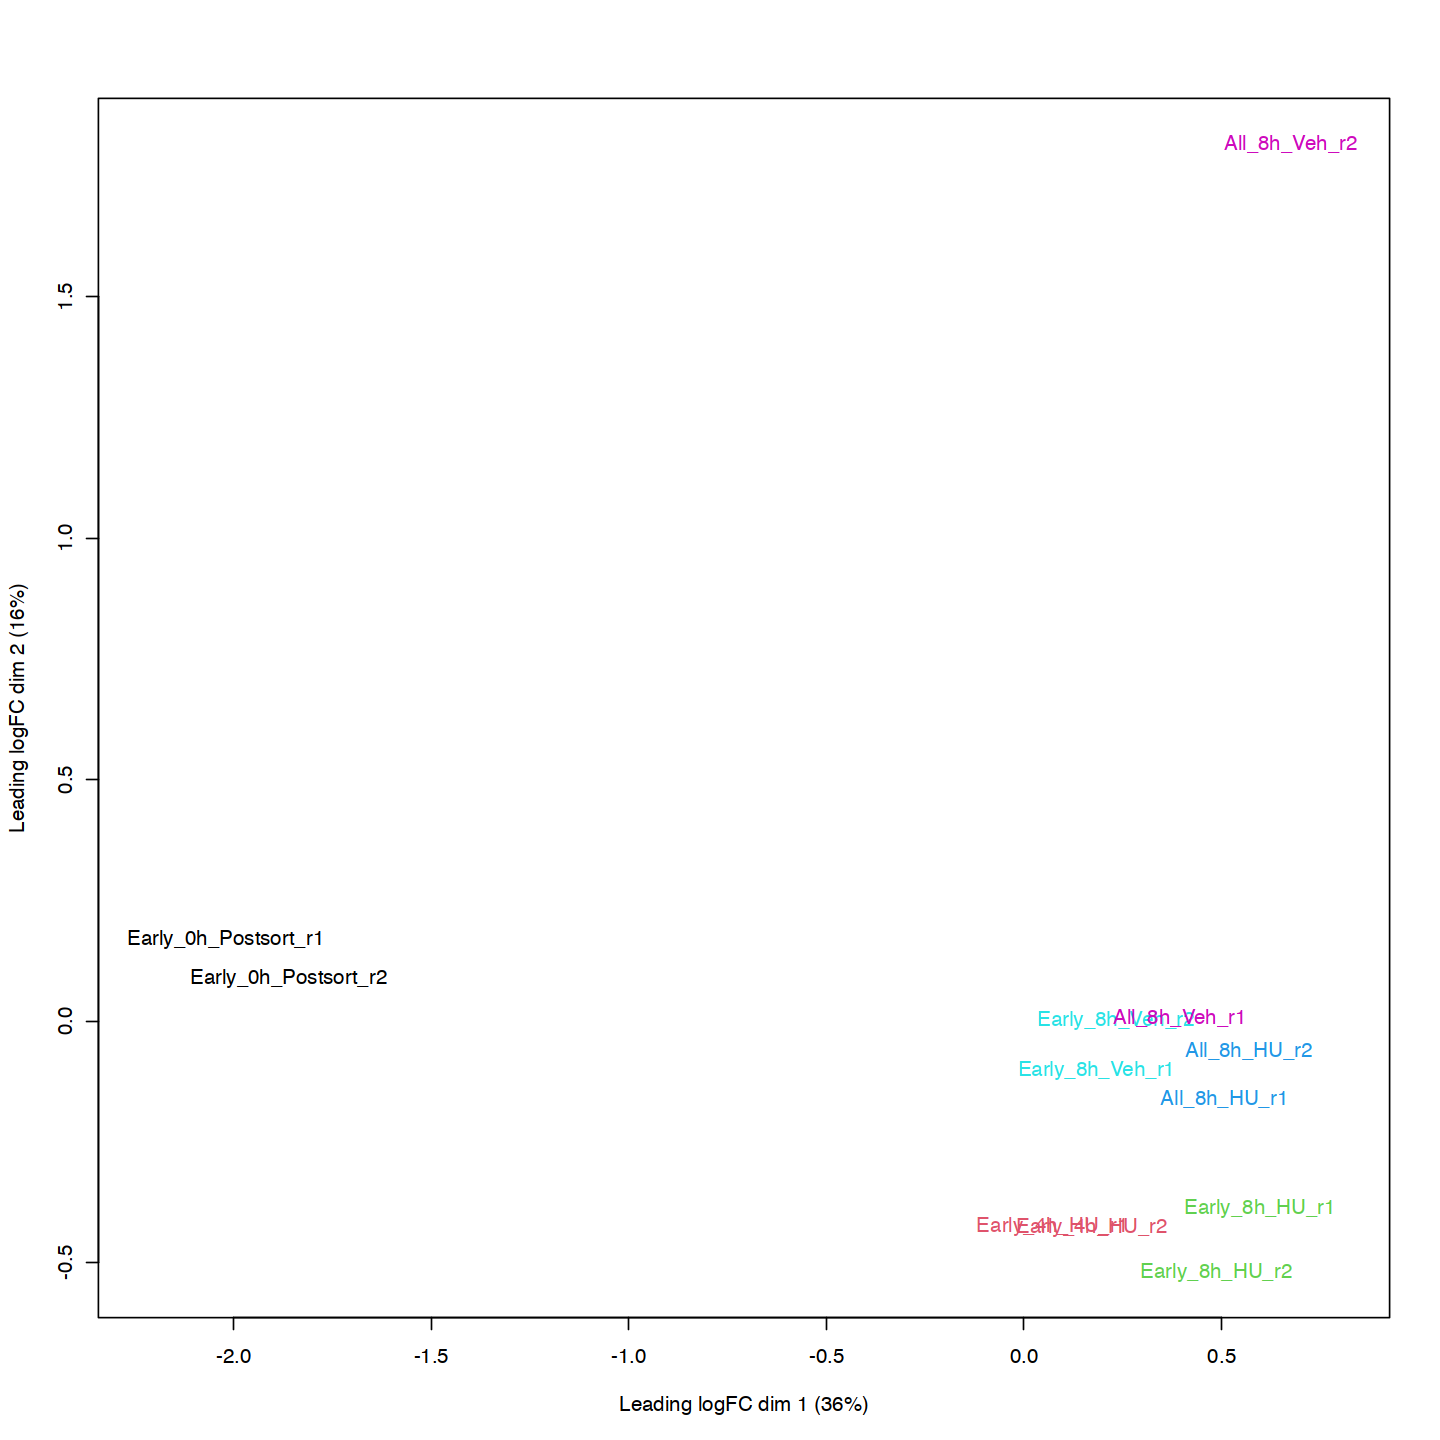

In [8]:
options(repr.plot.width=12, repr.plot.height=12)
plotMDS(d, col = as.numeric(factor(conds, level=unique(conds))))

condsAll_8_HU condsAll_8_Veh condsEarly_0_HU condsEarly_4_HU
MTND2P28      6.9524859      5.77046705     6.9926787      6.7345100      
hsa-mir-6723  2.9954572      2.66318226     3.3319567      3.2365529      
MTATP6P1      5.1418670      5.13030308     4.9162825      4.7007631      
RP11-206L10.2 1.3671747      1.04905251     0.9371516      0.9738394      
RP11-206L10.9 0.6730298      0.05602171     0.9208939      1.3185509      
RP11-206L10.8 0.6038444     -2.28724837    -0.2405330      0.4405242      
              condsEarly_8_HU condsEarly_8_Veh
MTND2P28      6.84429109       6.9085856      
hsa-mir-6723  3.18636467       3.1180710      
MTATP6P1      4.84968723       5.0931610      
RP11-206L10.2 1.10318849       0.8191211      
RP11-206L10.9 0.92560125       0.5198512      
RP11-206L10.8 0.06498613      -0.3433586

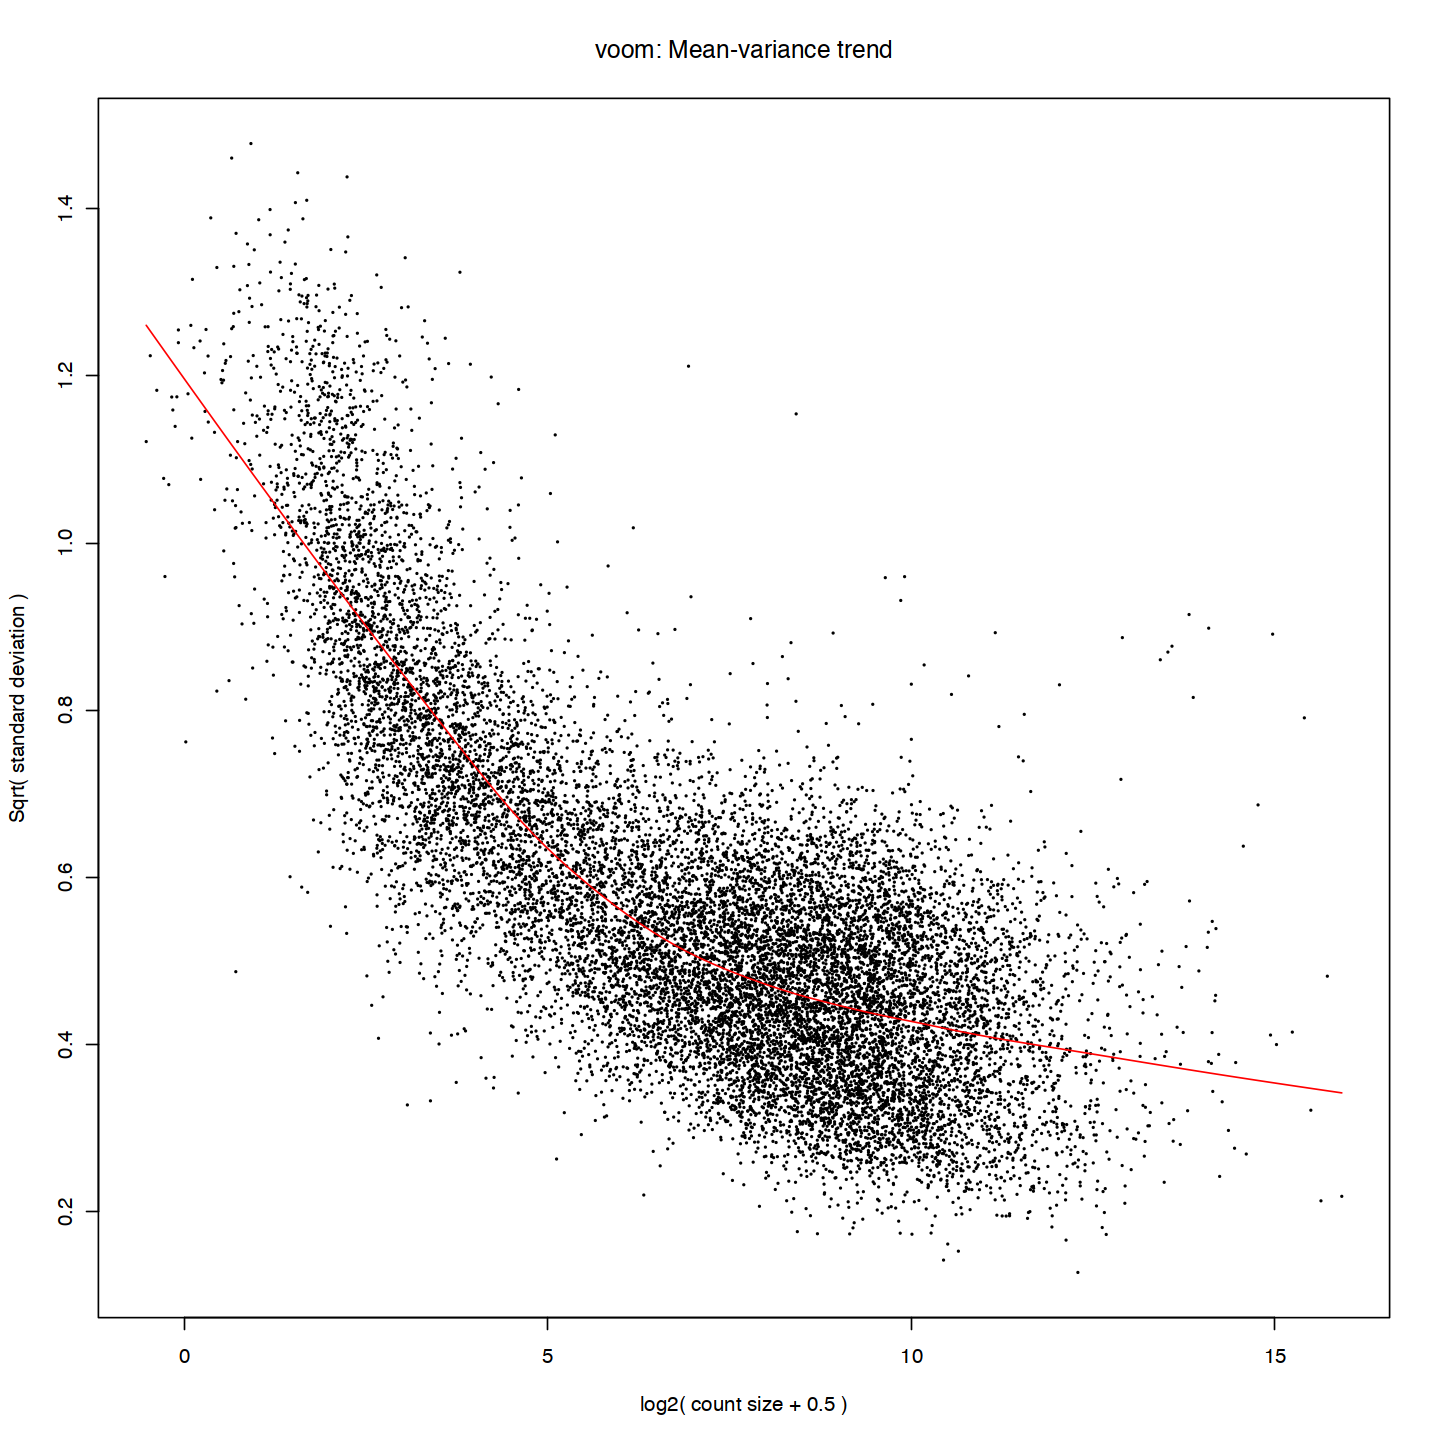

In [9]:
mm <- model.matrix(~0 + conds)
y <- voom(d, mm, plot = T)
fit <- lmFit(y, mm)
head(coef(fit))

In [10]:
norm_data = y$E
#write.csv(norm_data, "../221115_bd353_norm_data.csv", quote=F)

In [11]:
process_res = function(res, fit) {
    tmp <- contrasts.fit(fit, res)
    tmp <- eBayes(tmp)
    res <- topTable(tmp, sort.by = "P", n = Inf)
    
    res["gene"] = rownames(res)
    res["nlogpval"] = -log10(res$adj.P.Val)
    res["label"] = ""
    res_up = res[res$logFC > 0,]
    res_up[order(-res_up$t),][1:100,]$label = res_up[order(-res_up$t),][1:100,]$gene
    res_down = res[res$logFC < 0,]
    res_down[order(res_down$t),][1:100,]$label = res_down[order(res_down$t),][1:100,]$gene
    res = rbind(res_up, res_down)
    res = res[order(-res$t),]
    return(res)
}

In [12]:
conds

[1] "Early_0_HU"  "Early_0_HU"  "Early_4_HU"  "Early_4_HU"  "Early_8_HU" 
 [6] "Early_8_HU"  "All_8_HU"    "All_8_HU"    "Early_8_Veh" "Early_8_Veh"
[11] "All_8_Veh"   "All_8_Veh"

In [13]:
norm_data["CCNE2",]

Early_0h_Postsort_r1 Early_0h_Postsort_r2       Early_4h_HU_r1 
            5.778280             5.700487             6.122322 
      Early_4h_HU_r2       Early_8h_HU_r1       Early_8h_HU_r2 
            6.241628             6.790665             6.950585 
        All_8h_HU_r1         All_8h_HU_r2      Early_8h_Veh_r1 
            5.859480             5.314994             3.590063 
     Early_8h_Veh_r2        All_8h_Veh_r1        All_8h_Veh_r2 
            3.643042             3.613739             2.745783

In [14]:
all8_vs_0 <- process_res(makeContrasts(condsAll_8_HU - condsAll_8_Veh, levels = colnames(coef(fit))), fit)
early_4_vs_0 = process_res(makeContrasts(condsEarly_4_HU - condsEarly_0_HU, levels = colnames(coef(fit))), fit)
early_8_vs_0 = process_res(makeContrasts(condsEarly_8_HU - condsEarly_0_HU, levels = colnames(coef(fit))), fit)
early_8_vs_veh = process_res(makeContrasts(condsEarly_8_HU - condsEarly_8_Veh, levels = colnames(coef(fit))), fit)

In [15]:
early_vs_all = process_res(makeContrasts(condsEarly_0_HU - condsAll_8_Veh, levels = colnames(coef(fit))), fit)

Warning message:
"ggrepel: 126 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 126 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


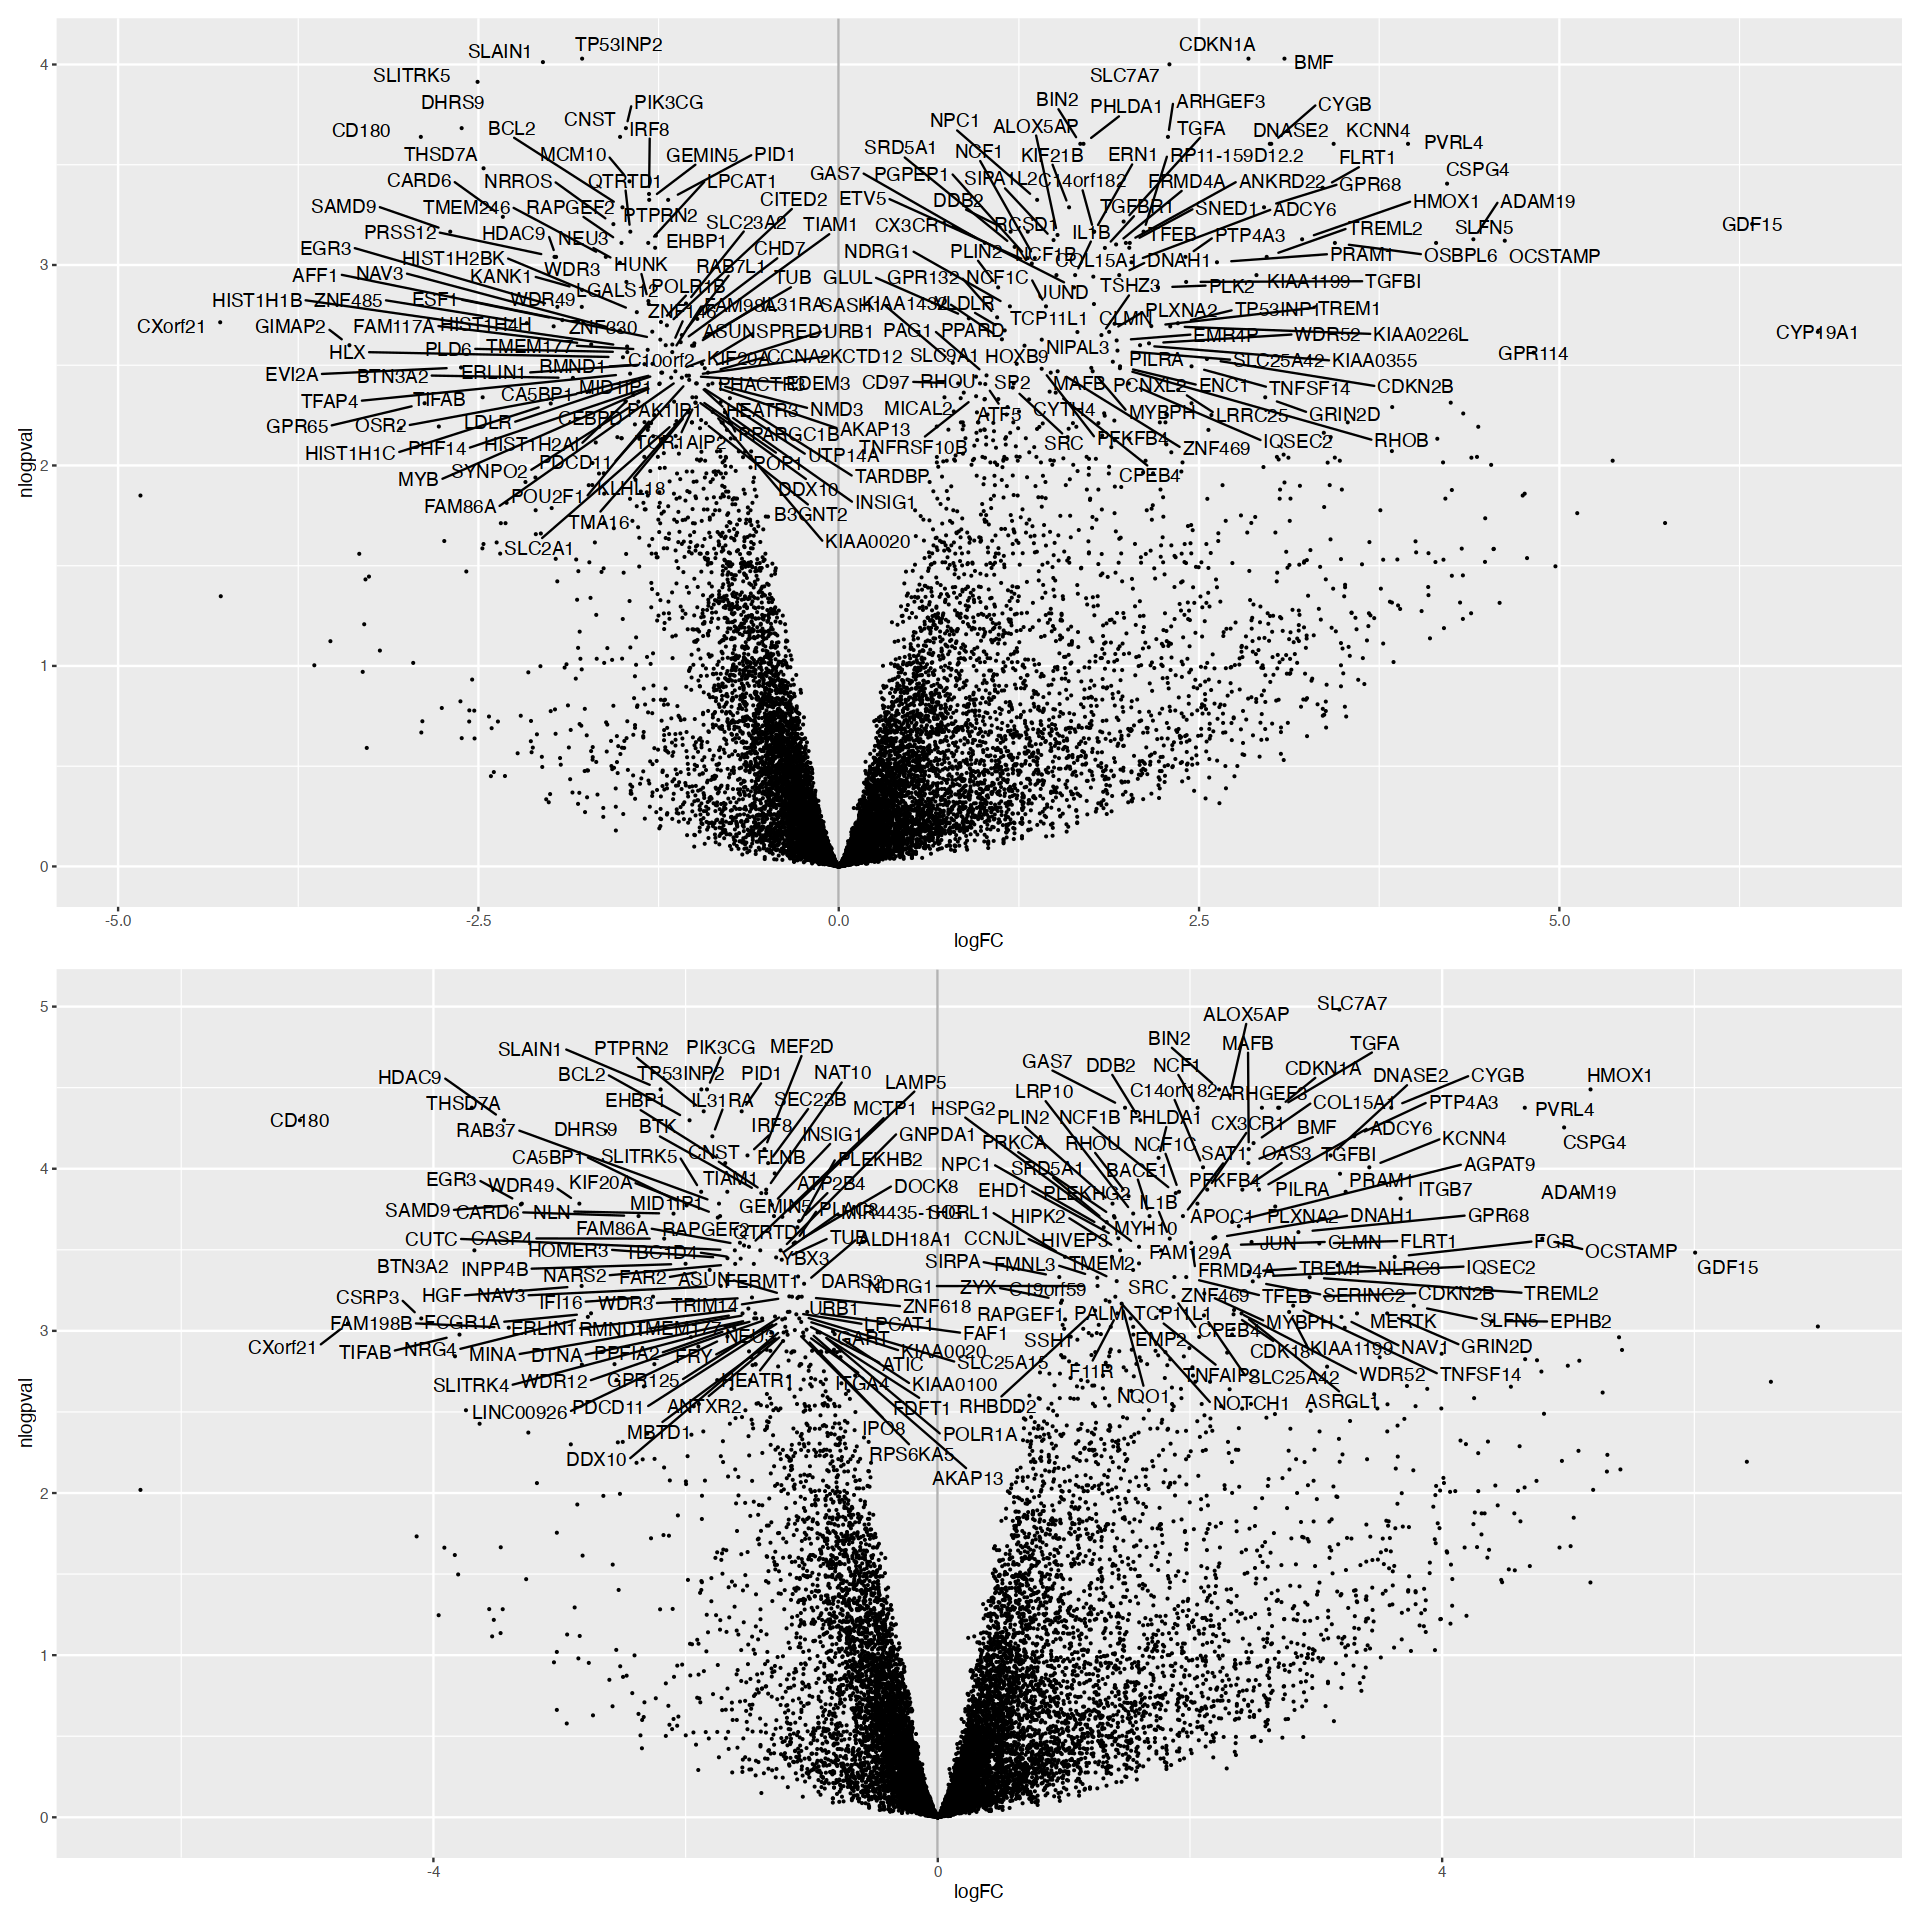

In [16]:
options(repr.plot.width=16, repr.plot.height=16)

g1 = ggplot(early_4_vs_0, aes(x=logFC, y=nlogpval, label=label)) + 
geom_point(size=0.1) + geom_text_repel(point.padding = 1, max.overlaps=50) +
geom_vline(xintercept=0, alpha=0.3)

g2 = ggplot(early_8_vs_0, aes(x=logFC, y=nlogpval, label=label)) + 
geom_point(size=0.1) + geom_text_repel(point.padding = 1, max.overlaps=50) +
geom_vline(xintercept=0, alpha=0.3)

g1 / g2

In [17]:
up4 = subset(early_4_vs_0, logFC > 1 & adj.P.Val < 0.05)
up8 = subset(early_8_vs_0, logFC > 1 & adj.P.Val < 0.05)

down4 = subset(early_4_vs_0, logFC < -1 & adj.P.Val < 0.05)
down8 = subset(early_8_vs_0, logFC < -1 & adj.P.Val < 0.05)

dim(up4)
dim(down4)

dim(up8)
dim(down8)

[1] 480   9

[1] 230   9

[1] 786   9

[1] 412   9

In [18]:
# enrichr
library(enrichR)

Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is Live!

WormEnrichr ... 
Connection is Live!

YeastEnrichr ... 
Connection is Live!

FishEnrichr ... 
Connection is Live!

OxEnrichr ... 
Connection is Live!



In [19]:
enriched_8h <- enrichr(rownames(subset(early_8_vs_0, logFC > 1 & adj.P.Val < 0.05)), 
                        c("KEGG_2021_Human", "GO_Biological_Process_2021", "Reactome_2022",
                          "Azimuth_Cell_Types_2021", "PanglaoDB_Augmented_2021", "HuBMAP_ASCT_plus_B_augmented_w_RNAseq_Coexpression"))

Uploading data to Enrichr... Done.
  Querying KEGG_2021_Human... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying Reactome_2022... Done.
  Querying Azimuth_Cell_Types_2021... Done.
  Querying PanglaoDB_Augmented_2021... Done.
  Querying HuBMAP_ASCT_plus_B_augmented_w_RNAseq_Coexpression... Done.
Parsing results... Done.


In [107]:
head(enriched_8h[[6]], 10)

Term                                 Overlap P.value      Adjusted.P.value
1  Myeloid Progenitor (Mop) (id:432)    31/103  3.696135e-14 1.241901e-11    
2  Non-Classical Monocyte (id:475)      28/100  4.526955e-12 7.605284e-10    
3  Macrophage (id:382)                  28/103  9.936598e-12 8.346742e-10    
4  Promonocyte (id:520)                 28/103  9.936598e-12 8.346742e-10    
5  Dendritic Cell Type 3 (Dc3) (id:157) 27/101  3.556134e-11 2.041300e-09    
6  Activated Dc (id:34)                 30/123  3.645179e-11 2.041300e-09    
7  Classical Monocyte (id:119)          27/102  4.560087e-11 2.188842e-09    
8  Cd16 Monocyte (id:87)                27/105  9.419151e-11 3.956043e-09    
9  Non Classical Monocyte (id:474)      26/100  1.604365e-10 5.989631e-09    
10 Cd14 Monocyte (id:86)                25/100  8.849965e-10 2.973588e-08    
   Old.P.value Old.Adjusted.P.value Odds.Ratio Combined.Score
1  0           0                    6.811003   210.6569      
2  0           0                    6.136313   160.2864      
3  0           0                    5.889916   149.2198      
4  0           0                    5.889916   149.2198      
5  0           0                    5.751770   138.3862      
6  0           0                    5.092905   122.4081      
7  0           0                    5.674777   135.1226      
8  0           0                    5.455641   125.9472      
9  0           0                    5.534080   124.8108      
10 0           0                    5.245585   109.3465      
   Genes                                                                                                                                                                                    
1  CD86;FCN1;CSF1R;NCF1;NCF2;NCF1B;NCF1C;LSP1;NOD2;IFI30;TREM1;FCGR3A;CYTH4;CD300LB;ITGAX;MS4A14;CD14;LRRC25;FCER1G;CD300A;HSPA7;NFAM1;PILRA;FGR;MARCO;HCK;TYROBP;ODF3B;FCGR2B;FCGR2C;S100A8
2  CD86;FCN1;CSF1R;NCF1;NCF2;NCF1B;NCF1C;FCGR3A;CYTH4;CLEC5A;C3AR1;CD300LB;ITGAX;MS4A14;VSIG4;LRRC25;FCER1G;CD93;CD300A;NFAM1;CXCR2P1;FGR;HCK;TYROBP;BIN2;PECAM1;FCGR2B;FCGR2C              
3  CD86;CSF1R;NCF1;NCF2;NCF1B;NCF1C;LSP1;ITGAL;PIK3R5;FCGR3A;CYTH4;C3AR1;CD300LB;ITGAX;MS4A14;VSIG4;CD14;LRRC25;FCER1G;CD300A;NFAM1;FGR;HCK;TYROBP;BIN2;ALOX5AP;FCGR2B;FCGR2C               
4  CX3CR1;CSF1R;NCF2;NCF1B;NCF1C;LSP1;TREM1;FCGR3A;CYTH4;C3AR1;CD300LB;ITGAX;MS4A14;CD14;LRRC25;FCER1G;RIPK3;CD300A;NFAM1;FGR;HCK;TYROBP;BIN2;TBXAS1;ALOX5AP;HCST;S100A8;CD244              
5  CD86;FCN1;CSF1R;NCF1;NCF2;NCF1B;NCF1C;TREM1;FCGR3A;CYTH4;CLEC5A;CD300LB;ITGAX;MS4A14;CD14;LRRC25;FCER1G;CD300A;NFAM1;CXCR2P1;FGR;HCK;TYROBP;BIN2;FCGR2B;FCGR2C;S100A8                    
6  CD86;CXCL9;NCF1;BCL2A1;NCF2;EBI3;NCF1B;TNFAIP2;NCF1C;GPR84;LSP1;IFI30;TREM1;TNFSF13B;MT2A;FCGR3A;C3AR1;ITGAX;CD14;IER3;FCER1G;CD300A;PILRA;MMP9;FGR;HCK;TYROBP;IL1B;ALOX5AP;FSCN1        
7  CD86;FCN1;CSF1R;NCF1;NCF2;NCF1B;NCF1C;TREM1;FCGR3A;CYTH4;CLEC5A;CD300LB;ITGAX;MS4A14;CD14;LRRC25;CR1;FCER1G;CD300A;NFAM1;PILRA;CXCR2P1;FGR;HCK;TYROBP;FCGR2C;S100A8                      
8  FCN1;CSF1R;NCF1;NCF2;NCF1C;TREM1;FCGR3A;CYTH4;CLEC5A;C3AR1;CD300LB;ITGAX;MS4A14;VSIG4;CD14;LRRC25;FCER1G;CD300A;NFAM1;PILRA;CXCR2P1;FGR;MARCO;HCK;TYROBP;FCGR2C;S100A8                   
9  CD86;ARHGAP9;NCF1;NCF1B;NCF1C;ITGAL;PIK3R5;FCGR3A;CYTH4;CD300LB;ITGAX;MS4A14;LRRC25;CR1;FCER1G;CD300A;NFAM1;NKG7;FGR;HCK;TYROBP;BIN2;ALOX5AP;FCGR2B;FCGR2C;CD244                         
10 FCN1;CSF1R;NCF2;NCF1C;TREM1;FCGR3A;CLEC5A;CD300LB;ITGAX;MS4A14;VSIG4;CD14;LRRC25;FCER1G;CD93;NFAM1;PILRA;CXCR2P1;TREML1;FGR;MARCO;HCK;TYROBP;FCGR2C;S100A8

In [72]:
k27ac_up = read.table("../../../bd345/intermediate_data/20230728-public-4.0.4-5nqDk4-hg38-all-gene.txt", skip = 1, sep='\t')
head(k27ac_up)
genes_related_to_k27ac_up = unique(k27ac_up$V1)
length(genes_related_to_k27ac_up)

V1     
1 A2M    
2 A3GALT2
3 A4GALT 
4 AAK1   
5 ABCA1  
6 ABCA6  
  V2                                                                                               
1 peak10123 (-2240)                                                                                
2 peak1400 (-26016)                                                                                
3 peak32960 (-53978)                                                                               
4 peak27196 (-4878), peak27185 (+42423), peak27184 (+49100), peak27183 (+51865), peak27180 (+70549)
5 peak47841 (-98843), peak47840 (-96361), peak47839 (-79026), peak47838 (-75707)                   
6 peak21262 (-19840)

[1] 2391

In [74]:
length(intersect(genes_related_to_k27ac_up, rownames(subset(early_8_vs_0, logFC > 1 & adj.P.Val < 0.05))))

[1] 240

In [21]:
degs = readRDS("../data/230621_bd262_data.rds")
b24_deg = degs[[1]]
b48_deg = degs[[2]]
p24_deg = degs[[3]]
p48_deg = degs[[4]]

b24_deg_up = subset(b24_deg, logFC > 1 & adj.P.Val < 0.05)
b24_deg_down = subset(b24_deg, logFC < -1 & adj.P.Val < 0.05)
p24_deg_up = subset(p24_deg, logFC > 1 & adj.P.Val < 0.05)
p24_deg_down = subset(p24_deg, logFC < -1 & adj.P.Val < 0.05)

In [22]:
early_degs = readRDS("../data/230729_bd287_thp1.rds")
b4_edeg = early_degs[[1]]  # BRQ 500nM 4h
b8_edeg = early_degs[[2]]  # BRQ 500nM 8h
b24_edeg = early_degs[[3]]  # BRQ 500nM 24h
h4_edeg = early_degs[[4]]  # HU 1mM 4h
h8_edeg = early_degs[[5]]  # HU 1mM 8h

In [23]:
b4_edeg_up = subset(b4_edeg, logFC > 1 & adj.P.Val < 0.05)
b4_edeg_down = subset(b4_edeg, logFC < -1 & adj.P.Val < 0.05)
dim(b4_edeg_up)
dim(b4_edeg_down)

b8_edeg_up = subset(b8_edeg, logFC > 1 & adj.P.Val < 0.05)
b8_edeg_down = subset(b8_edeg, logFC < -1 & adj.P.Val < 0.05)
dim(b8_edeg_up)
dim(b8_edeg_down)

b24_edeg_up = subset(b24_edeg, logFC > 1 & adj.P.Val < 0.05)
b24_edeg_down = subset(b24_edeg, logFC < -1 & adj.P.Val < 0.05)
dim(b24_edeg_up)
dim(b24_edeg_down)

[1] 19  9

[1] 30  9

[1] 136   9

[1] 287   9

[1] 1273    9

[1] 848   9

In [24]:
h4_edeg_up = subset(h4_edeg, logFC > 1 & adj.P.Val < 0.05)
h4_edeg_down = subset(h4_edeg, logFC < -1 & adj.P.Val < 0.05)
dim(h4_edeg_up)
dim(h4_edeg_down)

h8_edeg_up = subset(h8_edeg, logFC > 1 & adj.P.Val < 0.05)
h8_edeg_down = subset(h8_edeg, logFC < -1 & adj.P.Val < 0.05)
dim(h8_edeg_up)
dim(h8_edeg_down)


[1] 107   9

[1] 77  9

[1] 272   9

[1] 129   9

In [25]:
median(early_4_vs_0[rownames(b4_edeg_up),]$logFC, na.rm=T)  # highest
median(early_4_vs_0[rownames(b8_edeg_up),]$logFC, na.rm=T)
median(early_4_vs_0[rownames(b24_edeg_up),]$logFC, na.rm=T)
median(early_4_vs_0[rownames(h4_edeg_up),]$logFC, na.rm=T)  # also high
median(early_4_vs_0[rownames(h8_edeg_up),]$logFC, na.rm=T)  # also high
median(early_4_vs_0[rownames(b24_deg_up),]$logFC, na.rm=T)
median(early_4_vs_0[rownames(p24_deg_up),]$logFC, na.rm=T)
print("")
median(early_8_vs_0[rownames(b4_edeg_up),]$logFC, na.rm=T)
median(early_8_vs_0[rownames(b8_edeg_up),]$logFC, na.rm=T)
median(early_8_vs_0[rownames(b24_edeg_up),]$logFC, na.rm=T)  # <--
median(early_8_vs_0[rownames(h4_edeg_up),]$logFC, na.rm=T)
median(early_8_vs_0[rownames(h8_edeg_up),]$logFC, na.rm=T)  # highest
median(early_8_vs_0[rownames(b24_deg_up),]$logFC, na.rm=T)  # <--
median(early_8_vs_0[rownames(p24_deg_up),]$logFC, na.rm=T)

[1] 0.9385042

[1] 0.5356639

[1] 0.2611098

[1] 0.7130969

[1] 0.7419546

[1] 0.2190512

[1] 0.1856011

[1] ""


[1] 0.4135492

[1] 0.5516156

[1] 0.3261329

[1] 0.4548825

[1] 0.8684883

[1] 0.2855424

[1] 0.298383

Warning message:
"Removed 303 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 303 rows containing non-finite values (`stat_ydensity()`)."


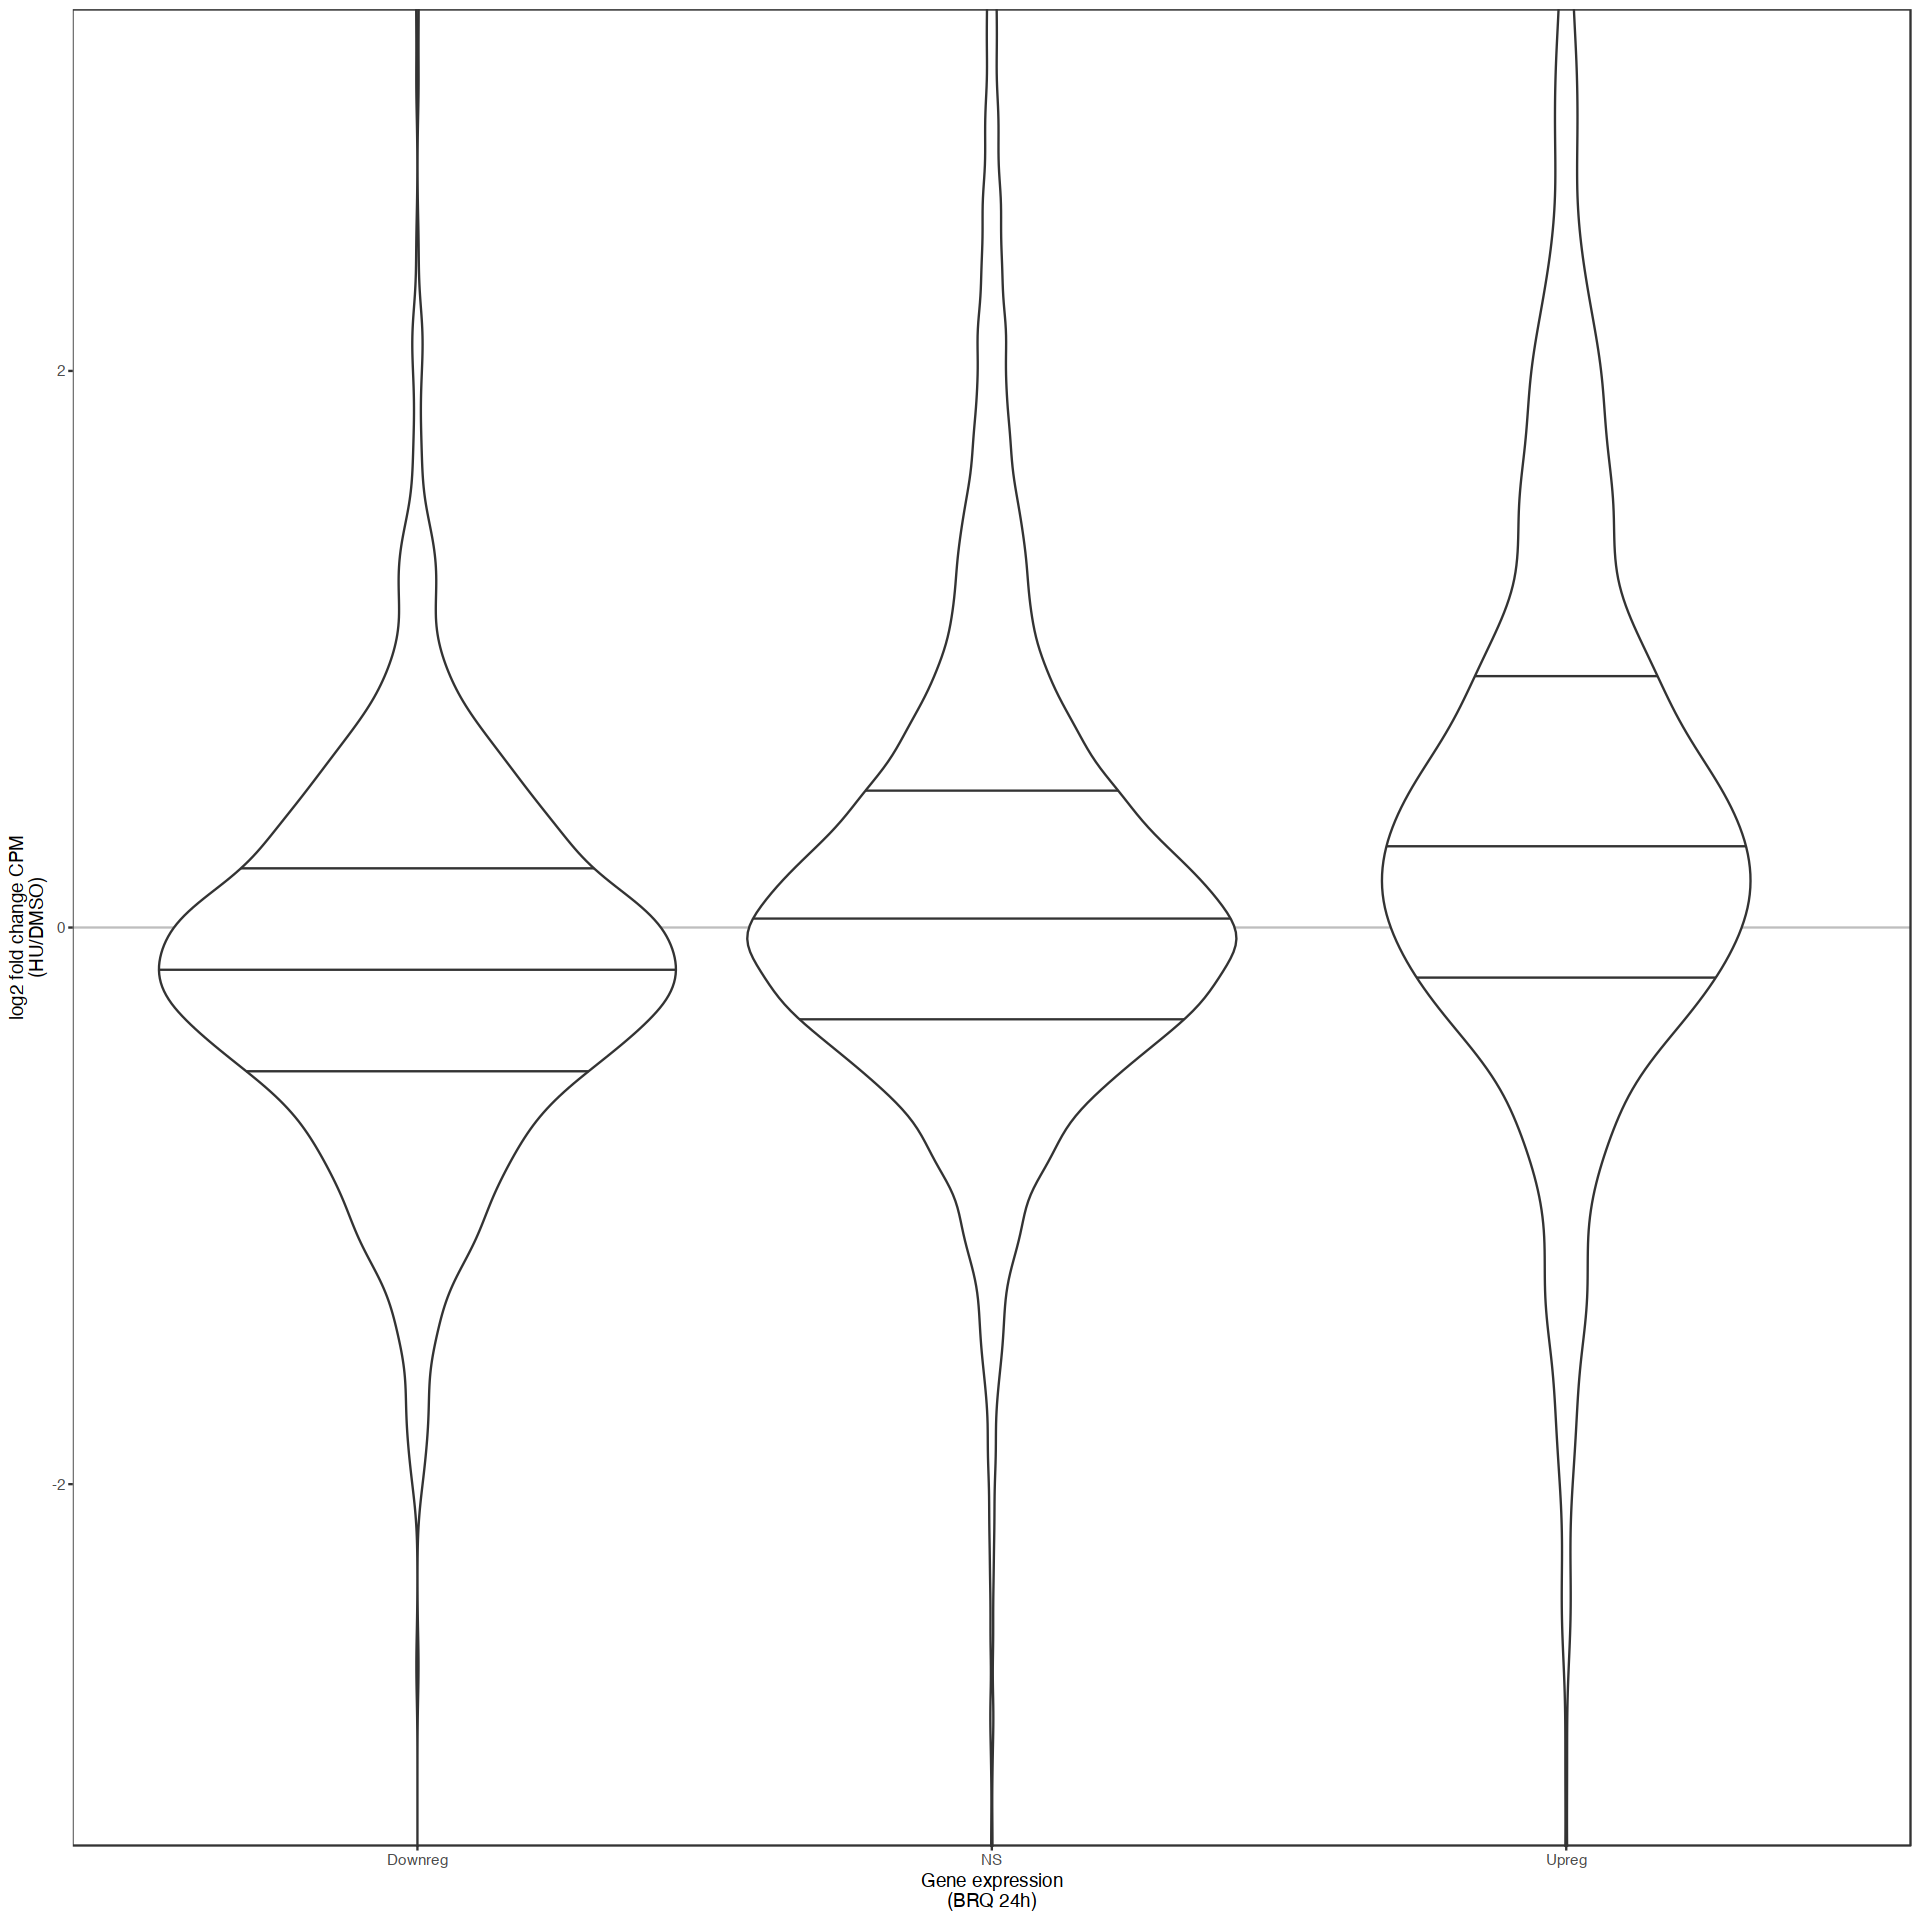

In [27]:
# options(repr.plot.width=6, repr.plot.height=4)
# plot(density(early_8_vs_0[rownames(b24_deg_up),]$logFC, na.rm=T))
# lines(density(early_8_vs_0[rownames(b24_deg_down),]$logFC, na.rm=T))

early_8_vs_0$b24_status = "NS"
early_8_vs_0[rownames(b24_deg_up),]$b24_status = "Upreg"
early_8_vs_0[rownames(b24_deg_down),]$b24_status = "Downreg"

g1 = ggplot(early_8_vs_0, aes(x=b24_status, y=logFC)) + 
geom_hline(yintercept=0, color="gray")+
#geom_boxplot(outlier.shape = NA) + 
geom_violin(draw_quantiles = c(.25,.5,.75)) +
coord_cartesian(ylim=c(-3,3)) + theme_bw() +
xlab("Gene expression\n(BRQ 24h)") + ylab("log2 fold change CPM\n(HU/DMSO)") +
theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank())

g1
ggsave("../output/230923_bd353_thp1_hu_early_rnaseq_chg.pdf", width=2, height=2.5)


In [28]:
median(early_4_vs_0[rownames(b4_edeg_down),]$logFC, na.rm=T)
median(early_4_vs_0[rownames(b8_edeg_down),]$logFC, na.rm=T)
median(early_4_vs_0[rownames(b24_edeg_down),]$logFC, na.rm=T) # <--
median(early_4_vs_0[rownames(h4_edeg_down),]$logFC, na.rm=T)  # also good
median(early_4_vs_0[rownames(h8_edeg_down),]$logFC, na.rm=T)  # best
median(early_4_vs_0[rownames(b24_deg_down),]$logFC, na.rm=T)  # <--
median(early_4_vs_0[rownames(p24_deg_down),]$logFC, na.rm=T)  
print("")

median(early_8_vs_0[rownames(b4_edeg_down),]$logFC, na.rm=T)
median(early_8_vs_0[rownames(b8_edeg_down),]$logFC, na.rm=T)
median(early_8_vs_0[rownames(b24_edeg_down),]$logFC, na.rm=T)
median(early_8_vs_0[rownames(h4_edeg_down),]$logFC, na.rm=T)
median(early_8_vs_0[rownames(h8_edeg_down),]$logFC, na.rm=T)  # best
median(early_8_vs_0[rownames(b24_deg_down),]$logFC, na.rm=T)
median(early_8_vs_0[rownames(p24_deg_down),]$logFC, na.rm=T)

[1] -0.2537097

[1] -0.1649534

[1] -0.1278196

[1] -0.3545395

[1] -0.3835706

[1] -0.06319984

[1] -0.1897081

[1] ""


[1] -0.1469668

[1] -0.1410299

[1] -0.1609009

[1] -0.2039052

[1] -0.4405247

[1] -0.1435702

[1] -0.2691011

In [29]:
length(intersect(rownames(h4_edeg_up), rownames(up8)))
length(intersect(rownames(h8_edeg_up), rownames(up8)))
length(intersect(rownames(b8_edeg_up), rownames(up8)))
length(intersect(rownames(b24_edeg_up), rownames(up8)))
length(intersect(rownames(b24_deg_up), rownames(up8)))

intersect(rownames(b24_edeg_up), rownames(up8))

[1] 27

[1] 88

[1] 31

[1] 159

[1] 150

[1] "PLIN2"         "SAT1"          "IL1B"          "GPR84"        
  [5] "ALOX5AP"       "TGM5"          "APOBEC3H"      "TP53I3"       
  [9] "CBX5"          "BCL2A1"        "C19orf59"      "TREM2"        
 [13] "BIN2"          "MAFB"          "ULBP2"         "CDKN1A"       
 [17] "ANKRD22"       "NQO1"          "TNFSF13B"      "DDB2"         
 [21] "IFIT3"         "C12orf5"       "IPCEF1"        "CXCL11"       
 [25] "ACAD8"         "GDF15"         "FUCA1"         "ARHGEF3"      
 [29] "PVRL4"         "RRM2B"         "TUBA4A"        "AP000769.1"   
 [33] "IFI30"         "MR1"           "PHLDA1"        "PHLDA2"       
 [37] "C18orf56"      "ASRGL1"        "TLR4"          "AC093673.5"   
 [41] "CTD-2547L24.3" "CREM"          "ZFP36L1"       "IL10"         
 [45] "LINC01021"     "CTD-2357A8.3"  "RELL1"         "AC116366.5"   
 [49] "PLK2"          "LUCAT1"        "SERPINE1"      "KIAA0226L"    
 [53] "SFXN5"         "CASP6"         "CYFIP2"        "IER5"         
 [57] "GPR68"         "SESN3"         "GNG2"          "PTGS2"        
 [61] "OASL"          "DAAM1"         "ENC1"          "CYP1A1"       
 [65] "FFAR2"         "E2F7"          "BLVRB"         "SGK1"         
 [69] "EMP2"          "DGKA"          "TGFA"          "FGD4"         
 [73] "EFCAB5"        "CDKN2B"        "LMNA"          "IFIT2"        
 [77] "RP11-511B23.2" "NT5DC1"        "FAM46C"        "LINC00475"    
 [81] "CYGB"          "CD86"          "RP11-297D21.4" "TRIB2"        
 [85] "CR1"           "IER3"          "PPL"           "CTD-2555K7.2" 
 [89] "CTA-390C10.10" "HP"            "CDCP1"         "RP11-466F5.8" 
 [93] "LTA"           "CCDC57"        "SLFN5"         "GADD45A"      
 [97] "KIAA0355"      "ACTA2"         "C3orf58"       "RP6-91H8.3"   
[101] "RP11-195F19.9" "MB21D2"        "MAP1A"         "MTSS1"        
[105] "CAPN5"         "FRMD4A"        "RAPH1"         "CYTH4"        
[109] "FCN1"          "TCP11L1"       "CD300A"        "TM4SF19-AS1"  
[113] "CEACAM1"       "TNFAIP2"       "STOX2"         "GAS6-AS1"     
[117] "FLRT1"         "CEP19"         "TNFSF14"       "ARHGAP5"      
[121] "BTG2"          "NRP1"          "C14orf93"      "SPATA33"      
[125] "JUN"           "ANXA8"         "CNIH3"         "LACC1"        
[129] "TRBV7-3"       "ABHD4"         "REEP1"         "MKL2"         
[133] "SEPT10"        "SLFN11"        "PIDD"          "GCOM1"        
[137] "PHLDA3"        "RIN2"          "C11orf71"      "SERPINI1"     
[141] "FAM212B"       "CRISPLD2"      "MYEOV"         "JUND"         
[145] "CAMP"          "PFKFB4"        "TP53INP1"      "CASS4"        
[149] "RASSF8"        "TBX15"         "RHOB"          "EMR4P"        
[153] "RP11-617F23.1" "LYPD6B"        "ARMC9"         "PCNXL2"       
[157] "TREML2"        "COQ10A"        "COLQ"

In [30]:
length(intersect(rownames(h4_edeg_down), rownames(down8)))
length(intersect(rownames(h8_edeg_down), rownames(down8)))
length(intersect(rownames(b8_edeg_down), rownames(down8)))
length(intersect(rownames(b24_edeg_down), rownames(down8)))
length(intersect(rownames(b24_deg_down), rownames(down8)))

intersect(rownames(b24_edeg_down), rownames(down8))

[1] 9

[1] 26

[1] 27

[1] 54

[1] 73

[1] "NEU3"       "HIST1H2BK"  "MAP2K6"     "FAM189B"    "HIST1H3J"  
 [6] "CCDC86"     "TIFAB"      "WNT10B"     "ST6GAL1"    "OSR2"      
[11] "PAXIP1-AS2" "FTCDNL1"    "RFX3"       "SLC2A1"     "PDE8A"     
[16] "ANKZF1"     "FAM86C2P"   "ANKRD18B"   "EPB41L4A"   "FAM72B"    
[21] "CDH6"       "ALG10"      "LPAR4"      "UNC5C"      "GBGT1"     
[26] "PRSS12"     "DUS4L"      "SCFD2"      "HOXA11"     "FCGR1A"    
[31] "NREP"       "DHODH"      "PIK3CB"     "PITPNC1"    "RRP9"      
[36] "PTCD2"      "HIST1H1B"   "UTP20"      "HIST1H1D"   "MT-TT"     
[41] "PFAS"       "FCGR1B"     "PDSS2"      "BCL2"       "UTP14A"    
[46] "HIST1H1C"   "FAF1"       "NAT10"      "LPCAT1"     "PTPRN2"    
[51] "IRF8"       "MYC"        "SCD"        "CXorf21"

In [31]:
b24_up = subset(b24_deg, logFC > 1 & adj.P.Val < 0.05)
dim(b24_up)

[1] 1135    9

In [76]:
enriched_brq <- enrichr(rownames(subset(b24_up, logFC > 1 & adj.P.Val < 0.05)), 
                        c("KEGG_2021_Human", "GO_Biological_Process_2021", "Reactome_2022",
                          "Azimuth_Cell_Types_2021", "PanglaoDB_Augmented_2021", "HuBMAP_ASCT_plus_B_augmented_w_RNAseq_Coexpression"))

Uploading data to Enrichr... Done.
  Querying KEGG_2021_Human... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying Reactome_2022... Done.
  Querying Azimuth_Cell_Types_2021... Done.
  Querying PanglaoDB_Augmented_2021... Done.
  Querying HuBMAP_ASCT_plus_B_augmented_w_RNAseq_Coexpression... Done.
Parsing results... Done.


In [82]:
head(enriched_brq[[6]], 10)

Term                                 Overlap P.value      Adjusted.P.value
1  Non-Classical Monocyte (id:475)      37/100  4.795726e-21 1.110253e-18    
2  Dendritic Cell Type 3 (Dc3) (id:157) 37/101  7.162925e-21 1.110253e-18    
3  Monocyte (id:423)                    36/103  1.491703e-19 1.541427e-17    
4  Cd16 Monocyte (id:87)                36/105  3.109825e-19 1.930938e-17    
5  Micro L1-6 Tyrobp Cd74 (id:421)      35/99   3.114416e-19 1.930938e-17    
6  Classical Monocyte (id:119)          35/102  9.463579e-19 4.889516e-17    
7  Promonocyte (id:520)                 35/103  1.356688e-18 6.008192e-17    
8  Macrophage-Resident (id:388)         34/102  8.362481e-18 3.240461e-16    
9  Macrophage (id:382)                  34/103  1.181472e-17 4.069513e-16    
10 Non Classical Monocyte (id:474)      33/100  3.594543e-17 1.114308e-15    
   Old.P.value Old.Adjusted.P.value Odds.Ratio Combined.Score
1  0           0                    10.056871  470.5264      
2  0           0                     9.899206  459.1783      
3  0           0                     9.190553  398.4031      
4  0           0                     8.923211  380.2586      
5  0           0                     9.347088  398.3082      
6  0           0                     8.927137  370.4911      
7  0           0                     8.795388  361.8553      
8  0           0                     8.536331  335.6722      
9  0           0                     8.412168  327.8826      
10 0           0                     8.401739  318.1279      
   Genes                                                                                                                                                                                                                                
1  FCN1;CSF1R;IGSF6;SIGLEC9;NCF1;CLEC12A;LST1;MS4A7;FGL2;FPR1;NCF1B;SLA;NCF1C;FPR2;MS4A4A;FCGR3A;CLEC7A;CLEC5A;TAGAP;C3AR1;CD300LB;TNFAIP8L2;CCR1;CD53;LRRC25;CD163;FCER1G;C1ORF162;LYZ;FGR;MS4A6A;DOK2;TYROBP;BIN2;PECAM1;CD300C;EVI2B 
2  FCN1;LILRA6;CSF1R;IGSF6;SIGLEC9;NCF1;CLEC12A;LST1;MS4A7;FGL2;FPR1;NCF1B;SLA;NCF1C;FPR2;CD1C;TREM1;MS4A4A;FCGR3A;CLEC7A;CLEC5A;CD300LB;FCER1A;CCR1;LRRC25;CD163;FCER1G;APOBR;C1ORF162;LYZ;FGR;MS4A6A;DOK2;TYROBP;BIN2;CD300C;S100A8   
3  FCN1;LILRA6;IGSF6;SIGLEC9;NCF1;CLEC12A;LST1;MS4A7;FGL2;FPR1;NCF1B;NCF1C;FPR2;TREM1;FCGR3A;CLEC7A;TAGAP;CD300LB;CASP1;CCR1;LRRC25;FCER1G;APOBR;C1ORF162;LYZ;FGR;TLR1;MS4A6A;DOK2;VCAN;TYROBP;BIN2;ALOX5AP;CD300C;S100A8;APOBEC3A      
4  FCN1;LILRA6;CSF1R;IL1RN;IGSF6;SERPINA1;SIGLEC9;NCF1;CLEC12A;LST1;MS4A7;FGL2;FPR1;NCF1C;FPR2;TREM1;CXCL16;MS4A4A;FCGR3A;CLEC7A;CLEC5A;C3AR1;CD300LB;LGALS9;CCR1;LRRC25;CD163;FCER1G;APOBR;C1ORF162;LYZ;FGR;MS4A6A;TYROBP;CD300C;S100A8
5  CX3CR1;CSF1R;IGSF6;SIGLEC9;NCF1;CLEC12A;GPR65;LST1;MS4A7;FGL2;FPR1;NCF1B;SLA;NCF1C;FCGR3A;TAGAP;TNFAIP8L2;CYTIP;CD53;LRRC25;CR1;FCER1G;LAPTM5;IL16;C1ORF162;APBB1IP;FGR;MS4A6A;DOK2;TYROBP;EVI2A;BIN2;ALOX5AP;TLR7;EVI2B             
6  FCN1;LILRA6;CSF1R;IGSF6;SIGLEC9;NCF1;SIRPD;CLEC12A;LST1;MS4A7;FGL2;FPR1;NCF1B;NCF1C;FPR2;TREM1;FCGR3A;CLEC7A;CLEC5A;CXCR2;CD300LB;FCER1A;CCR1;LRRC25;CR1;FCER1G;C1ORF162;LYZ;FGR;MS4A6A;VCAN;TYROBP;CD300C;S100A8;APOBEC3A           
7  CX3CR1;CSF1R;SIGLEC9;CLEC12A;FGL2;FPR1;NCF1B;NCF1C;FPR2;TREM1;FCGR3A;C3AR1;CD300LB;CASP1;FCER1A;LGALS9;TNFAIP8L2;GBP2;CCR1;LRRC25;C11ORF21;FCER1G;APOBR;C1ORF162;LYZ;FGR;TLR1;MS4A6A;DOK2;TYROBP;BIN2;TBXAS1;ALOX5AP;CD300C;S100A8   
8  FCN1;LILRA6;CSF1R;IGSF6;SIGLEC9;CLEC12A;LST1;MS4A7;FGL2;FPR1;SLA;FPR2;TREM1;MS4A4A;FCGR3A;CLEC7A;CLEC5A;C3AR1;CD300LB;CASP1;CCR1;CD53;LRRC25;CD163;FCER1G;C1ORF162;LYZ;FGR;TLR1;MS4A6A;TYROBP;PECAM1;IL7R;EVI2B                      
9  CSF1R;IGSF6;SIGLEC9;NCF1;CLEC12A;LST1;MS4A7;FGL2;FPR1;NCF1B;SLA;NCF1C;MS4A4A;FCGR3A;CLEC7A;TAGAP;C3AR1;CD300LB;CCR1;CD53;LRRC25;CD163;FCER1G;LAPTM5;C1ORF162;LYZ;FGR;MS4A6A;DOK2;TYROBP;BIN2;ALOX5AP;CD300C;EVI2B                    
10 IGSF6;SIGLEC9;NCF1;CLEC12A;GPR65;LST1;MS4A7;FGL2;NCF1B;SLA;NCF1C;FCGR3A;CLEC7A;TAGAP;CD300LB;TNFAIP8L2;CYTIP;CCR1;CD53;LRRC25;CR1;

In [64]:
z = intersect(rownames(subset(early_8_vs_0, logFC > 1 & adj.P.Val < 0.05)), rownames(b24_up))
z
length(z)

[1] "BIN2"          "MAFB"          "DDB2"          "JUN"          
  [5] "NCF1"          "ALOX5AP"       "HMOX1"         "PHLDA1"       
  [9] "ARHGEF3"       "GPR68"         "PVRL4"         "PECAM1"       
 [13] "PFKFB4"        "PLIN2"         "NCF1C"         "KCNN4"        
 [17] "CX3CR1"        "CYGB"          "FRMD4A"        "C14orf182"    
 [21] "PHLDA3"        "SAT1"          "NCF1B"         "SESN3"        
 [25] "TMEM2"         "LMNA"          "TREML2"        "GPR84"        
 [29] "ADORA3"        "TNFSF14"       "C19orf59"      "TREM1"        
 [33] "TGFBI"         "IL1B"          "PTGS2"         "KIAA1199"     
 [37] "NQO1"          "GDF15"         "TLR4"          "ABTB2"        
 [41] "FGR"           "CCNJL"         "ANKRD22"       "SFXN5"        
 [45] "RHOB"          "EMP2"          "SH3TC1"        "ECM1"         
 [49] "ENC1"          "C3orf58"       "CYFIP2"        "OCSTAMP"      
 [53] "RELL1"         "LRRC25"        "ASRGL1"        "CDKN2B"       
 [57] "IPCEF1"        "PLK2"          "TP53I3"        "CRISPLD2"     
 [61] "HSPA1B"        "ACTA2"         "LUCAT1"        "TGM5"         
 [65] "COL7A1"        "OASL"          "NPTXR"         "CSF1R"        
 [69] "APOBEC3H"      "CTD-2547L24.3" "IFIT3"         "ZFP36L1"      
 [73] "SPATA33"       "CR1"           "TUBA4A"        "TREM2"        
 [77] "SERTAD1"       "SLFN11"        "PHLDA2"        "IER3"         
 [81] "BTG2"          "C18orf56"      "EFNA4"         "GAS6-AS1"     
 [85] "CEP19"         "AC093673.5"    "FFAR2"         "CTD-2357A8.3" 
 [89] "LTA"           "TYROBP"        "CLEC5A"        "CYP1A1"       
 [93] "CPXM1"         "FCN1"          "LACC1"         "LINC00475"    
 [97] "ADRB2"         "UCN2"          "PTX3"          "AC116366.5"   
[101] "LMO7"          "TNFSF13B"      "CXCL11"        "FUCA1"        
[105] "HTRA1"         "ULBP2"         "GCOM1"         "CTD-2547L24.4"
[109] "B3GALT4"       "TP53I11"       "C12orf5"       "TBXAS1"       
[113] "C3AR1"         "BCL2A1"        "GPRIN3"        "NINJ2"        
[117] "AQP3"          "CDCP1"         "ST3GAL6"       "LYPD6B"       
[121] "CEACAM1"       "IFIT2"         "IL10"          "CREM"         
[125] "TSGA10"        "FCRLB"         "HP"            "TBX15"        
[129] "AP000769.1"    "ADM"           "ICAM4"         "SERPINI1"     
[133] "NRP1"          "RP11-666A8.8"  "ST5"           "S100A8"       
[137] "SERPINE1"      "FCER1G"        "CTD-2555K7.2"  "SGK1"         
[141] "TM4SF19-AS1"   "NGFR"          "DUSP6"         "RND3"         
[145] "FCGR3A"        "MYLPF"         "RP4-737E23.2"  "RP11-466F5.8" 
[149] "MTSS1"         "RP11-511B23.2" "MYEOV"         "RIN2"         
[153] "CD300LB"       "AC093627.9"    "CASP6"         "S100A2"       
[157] "PRDM1"         "CASS4"         "ATP6V0D2"      "IFI30"        
[161] "RP11-297D21.4" "IL10RB-AS1"    "LTB"           "LINC01004"    
[165] "MIR143HG"      "ACKR3"         "LRRK2"         "AC109826.1"   
[169] "MYLK-AS1"      "CSTF3-AS1"     "LINC00683"     "LINC01021"    
[173] "PMF1-BGLAP"    "TNFAIP6"       "GABRA4"        "RGS20"        
[177] "SULF2"         "DNAJC3-AS1"    "RP11-65J3.1"   "RP11-111M22.3"
[181] "PTCHD4"        "LINC00892"     "STXBP5-AS1"    "NPHP1"        
[185] "RP6-159A1.3"   "SHC4"

[1] 186

In [75]:
length(intersect(genes_related_to_k27ac_up, z))

[1] 72

In [93]:
enriched_inters <- enrichr(z, 
                        c("KEGG_2021_Human", "GO_Biological_Process_2021", "Reactome_2022",
                          "Azimuth_Cell_Types_2021", "PanglaoDB_Augmented_2021", "HuBMAP_ASCT_plus_B_augmented_w_RNAseq_Coexpression"))

Uploading data to Enrichr... Done.
  Querying KEGG_2021_Human... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying Reactome_2022... Done.
  Querying Azimuth_Cell_Types_2021... Done.
  Querying PanglaoDB_Augmented_2021... Done.
  Querying HuBMAP_ASCT_plus_B_augmented_w_RNAseq_Coexpression... Done.
Parsing results... Done.


In [99]:
head(enriched_inters[[6]], 10)

Term                                                        Overlap
1  Promonocyte (id:520)                                        16/103 
2  Non-Classical Monocyte (id:475)                             15/100 
3  Dendritic Cell Type 3 (Dc3) (id:157)                        15/101 
4  Activated Dc (id:34)                                        16/123 
5  Classical Monocyte (id:119)                                 15/102 
6  Monocyte (id:423)                                           14/103 
7  Myeloid Progenitor (Mop) (id:432)                           14/103 
8  Lymphatic Endothelial Cell-Subcapsular Sinus Floor (id:373) 14/104 
9  Cd16 Monocyte (id:87)                                       14/105 
10 Micro L1-6 Tyrobp Cd74 (id:421)                             13/99  
   P.value      Adjusted.P.value Old.P.value Old.Adjusted.P.value Odds.Ratio
1  1.807714e-15 3.760044e-13     0           0                    21.34091  
2  2.419511e-14 1.363718e-12     0           0                    20.36017  
3  2.818711e-14 1.363718e-12     0           0                    20.12240  
4  3.243784e-14 1.363718e-12     0           0                    17.33436  
5  3.278169e-14 1.363718e-12     0           0                    19.89010  
6  7.388730e-13 2.195508e-11     0           0                    18.03959  
7  7.388730e-13 2.195508e-11     0           0                    18.03959  
8  8.469483e-13 2.202065e-11     0           0                    17.83824  
9  9.693955e-13 2.240381e-11     0           0                    17.64132  
10 7.860652e-12 1.486378e-10     0           0                    17.23780  
   Combined.Score
1  724.4536      
2  638.3446      
3  627.8171      
4  538.3957      
5  617.5658      
6  503.9115      
7  503.9115      
8  495.8521      
9  487.9961      
10 440.7559      
   Genes                                                                                                  
1  CX3CR1;LRRC25;CSF1R;FCER1G;NCF1B;NCF1C;TREM1;FGR;FCGR3A;TYROBP;BIN2;TBXAS1;ALOX5AP;C3AR1;CD300LB;S100A8
2  FCN1;LRRC25;CSF1R;FCER1G;NCF1;NCF1B;NCF1C;FGR;FCGR3A;TYROBP;BIN2;CLEC5A;C3AR1;CD300LB;PECAM1           
3  FCN1;LRRC25;CSF1R;FCER1G;NCF1;NCF1B;NCF1C;TREM1;FGR;FCGR3A;TYROBP;BIN2;CLEC5A;CD300LB;S100A8           
4  FCER1G;NCF1;BCL2A1;NCF1B;NCF1C;GPR84;IFI30;TREM1;TNFSF13B;FGR;FCGR3A;TYROBP;IL1B;ALOX5AP;C3AR1;IER3    
5  FCN1;LRRC25;CSF1R;CR1;FCER1G;NCF1;NCF1B;NCF1C;TREM1;FGR;FCGR3A;TYROBP;CLEC5A;CD300LB;S100A8            
6  FCN1;LRRC25;FCER1G;NCF1;NCF1B;NCF1C;TREM1;FGR;FCGR3A;TYROBP;BIN2;ALOX5AP;CD300LB;S100A8                
7  FCN1;LRRC25;CSF1R;FCER1G;NCF1;NCF1B;NCF1C;IFI30;TREM1;FGR;FCGR3A;TYROBP;CD300LB;S100A8                 
8  FCER1G;TNFAIP6;BCL2A1;PRDM1;GPR84;PTGS2;SAT1;TREM1;IFIT3;TNFSF13B;TYROBP;IL1B;CLEC5A;C3AR1             
9  FCN1;LRRC25;CSF1R;FCER1G;NCF1;NCF1C;TREM1;FGR;FCGR3A;TYROBP;CLEC5A;C3AR1;CD300LB;S100A8                
10 CX3CR1;LRRC25;CSF1R;CR1;FCER1G;NCF1;NCF1B;NCF1C;FGR;FCGR3A;TYROBP;BIN2;ALOX5AP

In [108]:
library(fgsea)

In [129]:
pathways = list()
pathways[["brq_24h"]] = rownames(b24_up)
pathways[["k27ac_up"]] = genes_related_to_k27ac_up


In [130]:
ranks = early_8_vs_0$logFC
names(ranks) = rownames(early_8_vs_0)
fgseaRes = fgsea(pathways=pathways, 
                 stats = ranks)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.18% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."


[1] 0.2568206

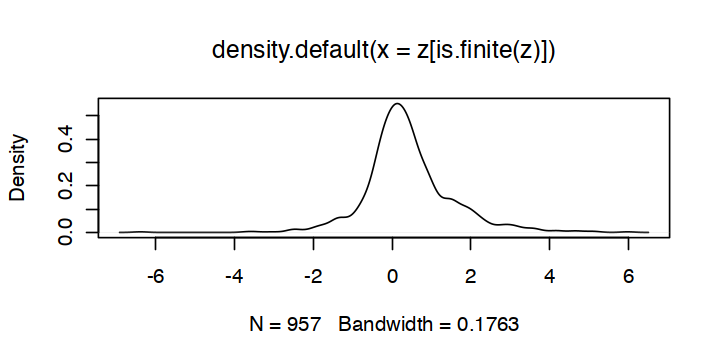

[1] 0.08442035

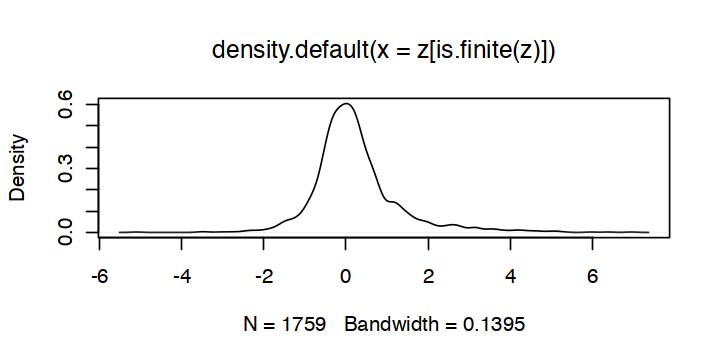

In [141]:
z = ranks[pathways[["brq_24h"]]]
plot(density(z[is.finite(z)]))
median(z, na.rm=T)

z = ranks[pathways[["k27ac_up"]]]
plot(density(z[is.finite(z)]))
median(z, na.rm=T)

In [132]:
fgseaRes

pathway  pval         padj         log2err   ES        NES      size
1 brq_24h  3.313147e-13 6.626293e-13 0.9325952 0.4511986 1.560807  957
2 k27ac_up 6.463494e-06 6.463494e-06 0.6105269 0.3637775 1.267171 1759
  leadingEdge                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

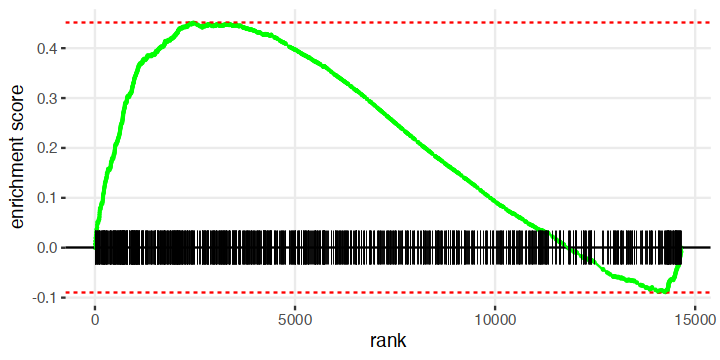

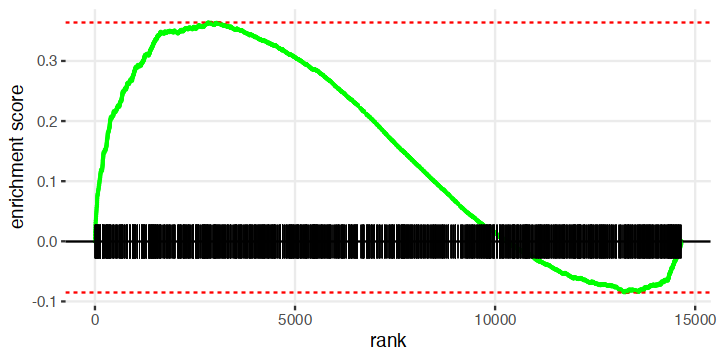

In [131]:
options(repr.plot.width=6, repr.plot.height=3)
plotEnrichment(pathways[["brq_24h"]], ranks)

plotEnrichment(pathways[["k27ac_up"]], ranks)


Warning message:
"ggrepel: 126 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 116 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


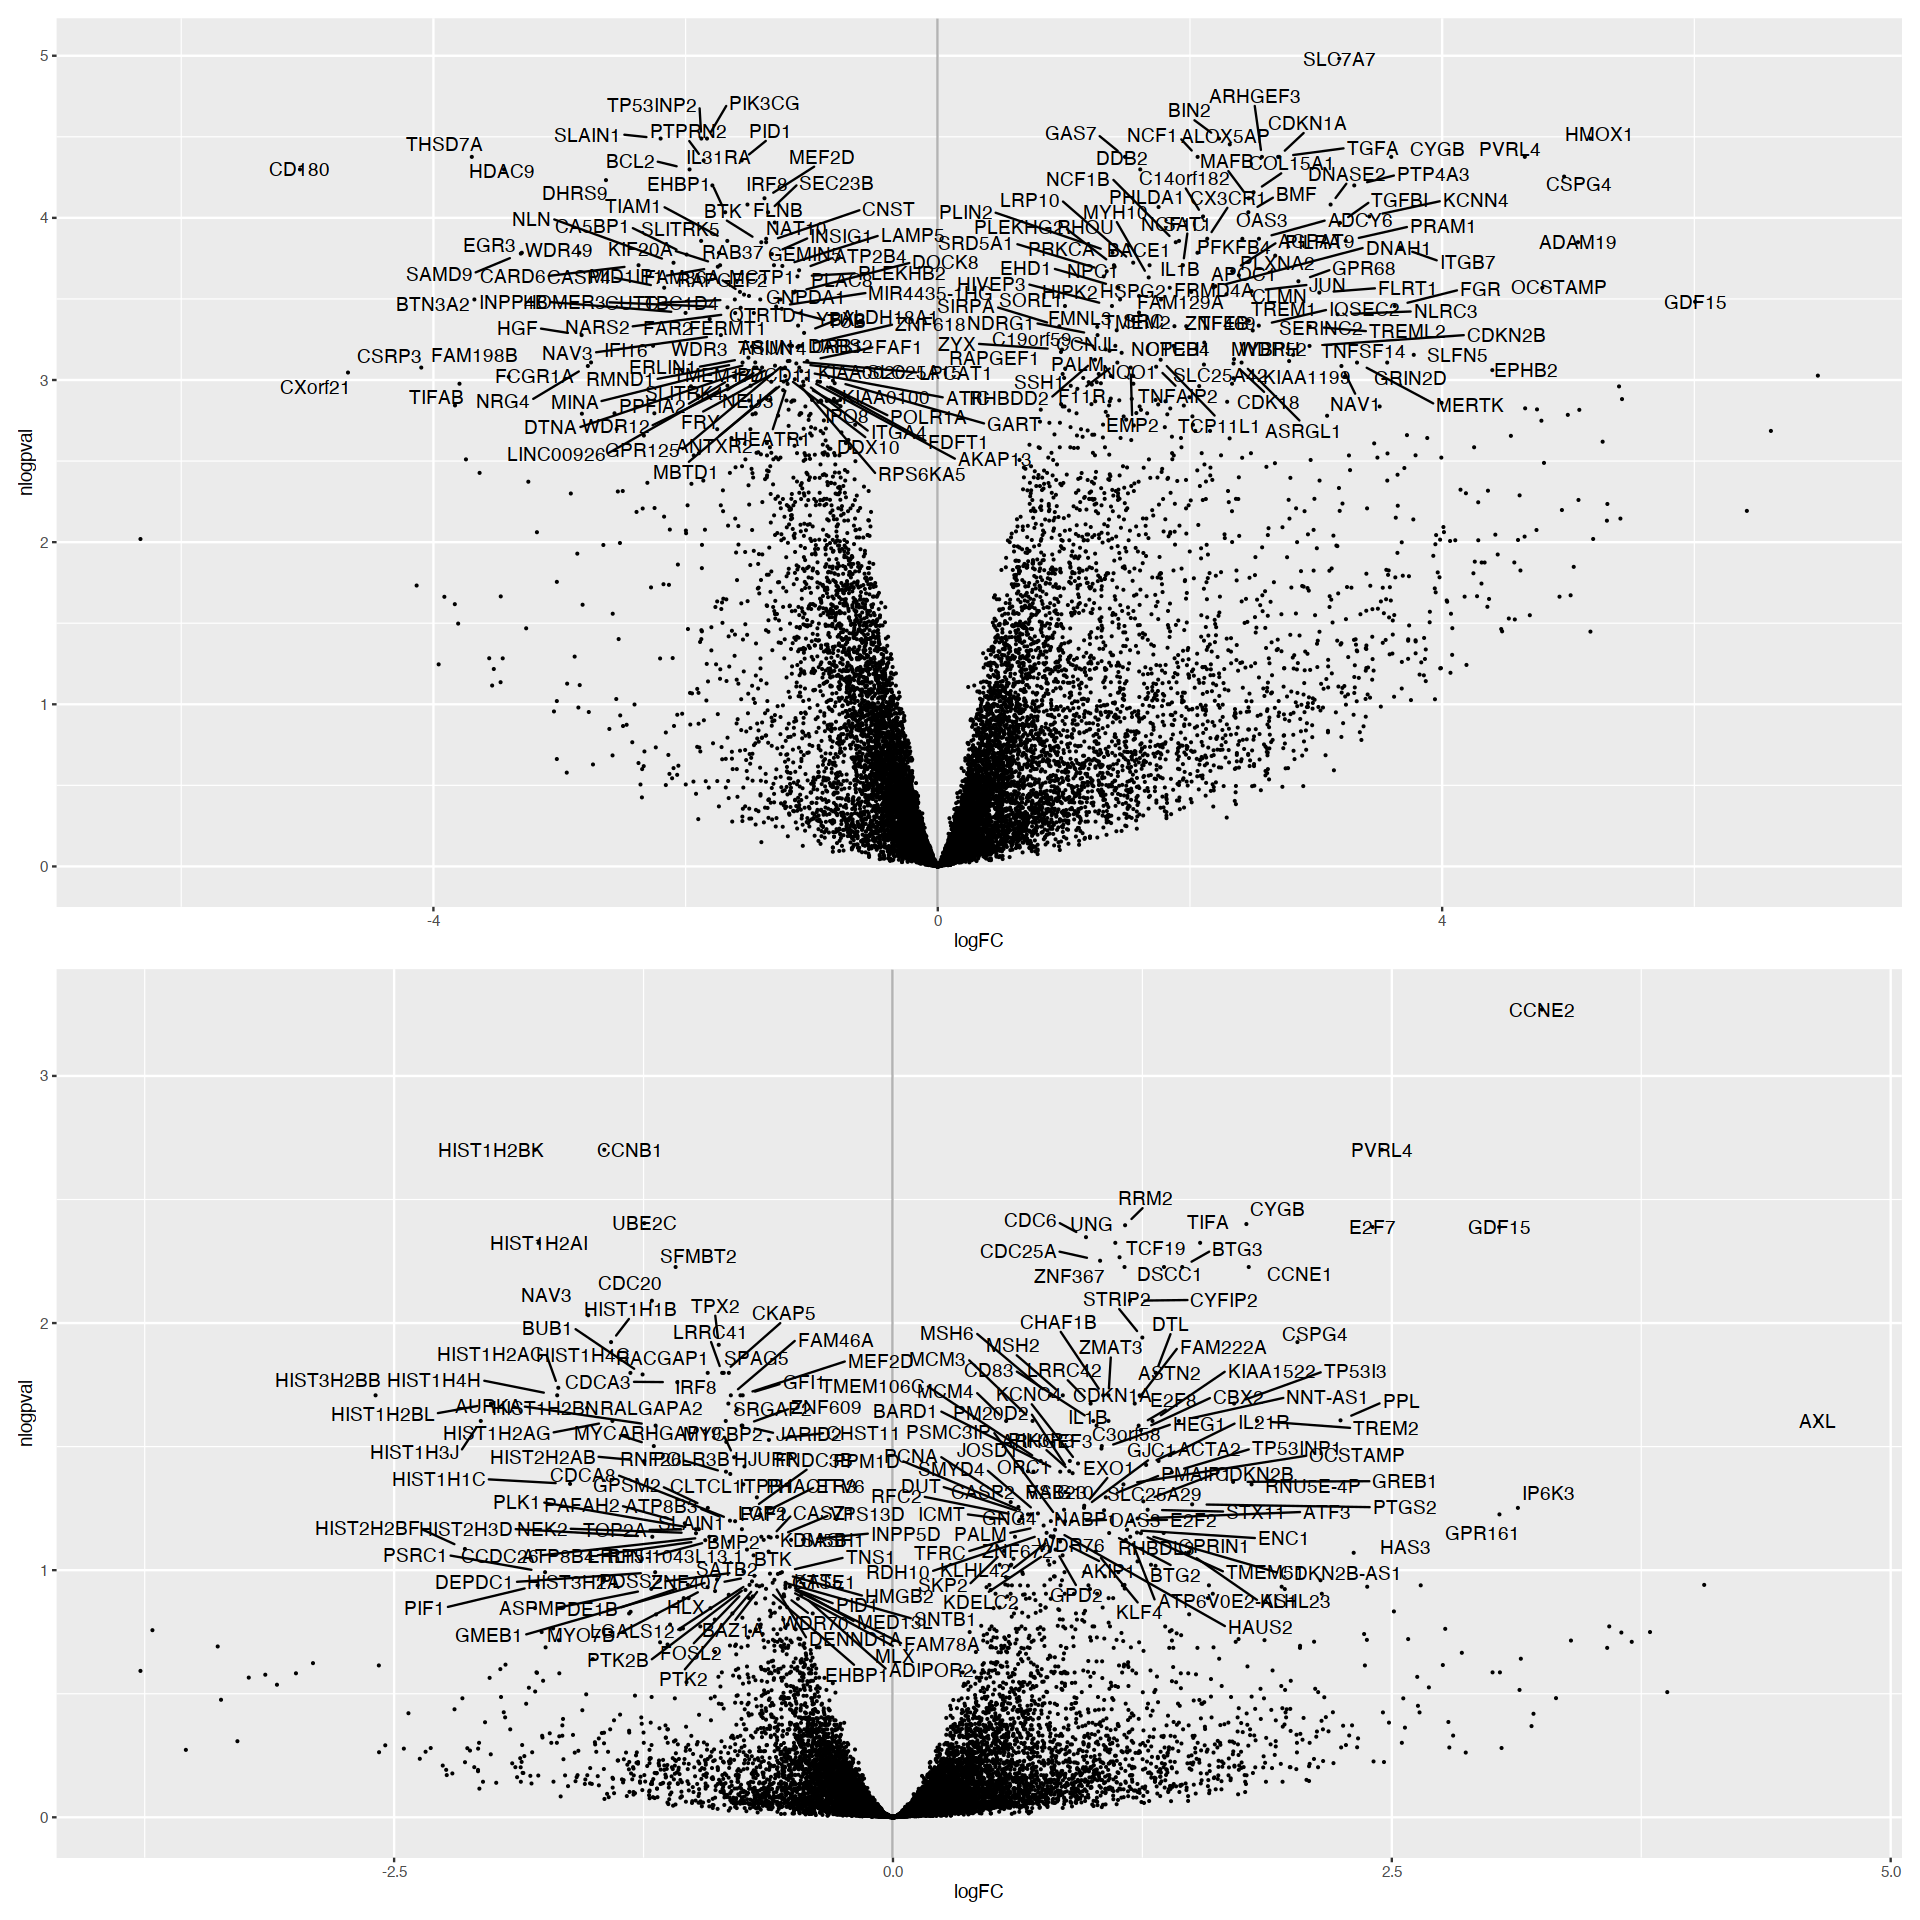

In [30]:
options(repr.plot.width=16, repr.plot.height=16)

g1 = ggplot(early_8_vs_0, aes(x=logFC, y=nlogpval, label=label)) + 
geom_point(size=0.1) + geom_text_repel(point.padding = 1, max.overlaps=50) +
geom_vline(xintercept=0, alpha=0.3)

g2 = ggplot(early_8_vs_veh, aes(x=logFC, y=nlogpval, label=label)) + 
geom_point(size=0.1) + geom_text_repel(point.padding = 1, max.overlaps=50) +
geom_vline(xintercept=0, alpha=0.3)

g1 / g2

Warning message:
"ggrepel: 69 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


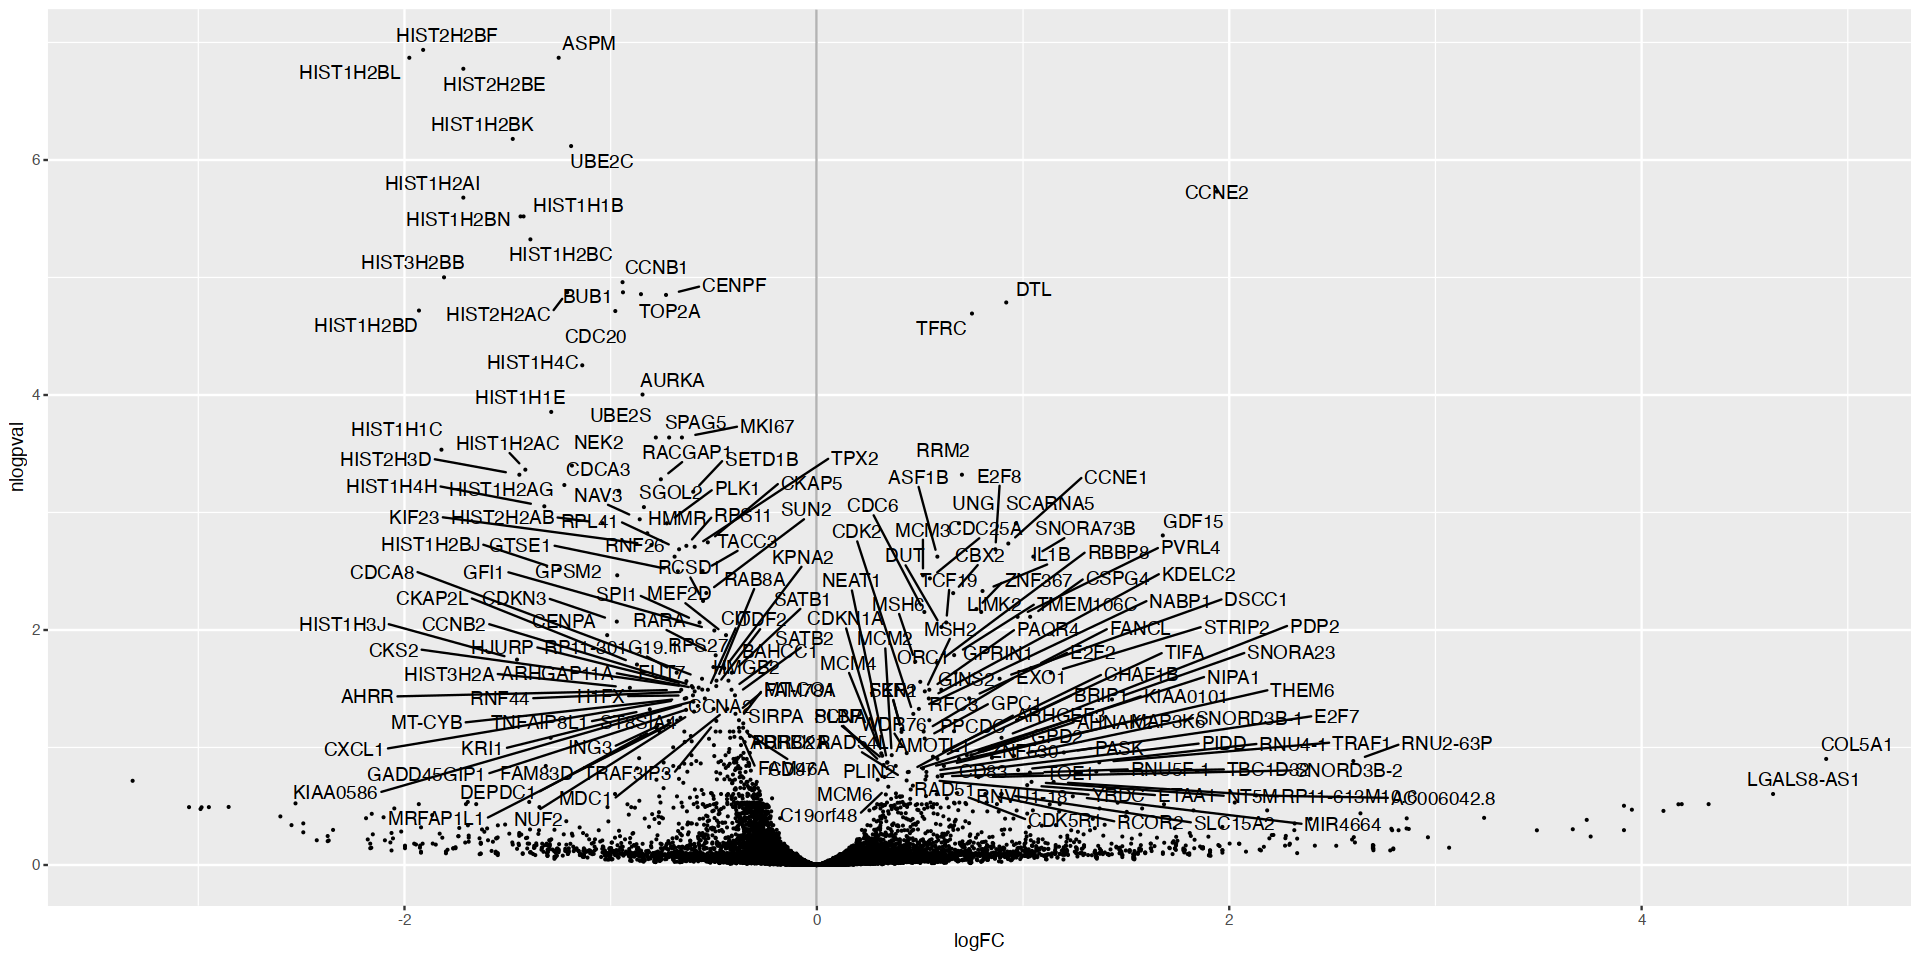

In [34]:
options(repr.plot.width=16, repr.plot.height=8)
g1 = ggplot(all8_vs_0, aes(x=logFC, y=nlogpval, label=label)) + 
geom_point(size=0.1) + geom_text_repel(point.padding = 1, max.overlaps=50) +
geom_vline(xintercept=0, alpha=0.3)

g1

In [40]:
genes = c("MAFB", "JUN", "SPI1", "IRF8", "MERTK", "IL7R", "CD86", "CD163", "FCAR", "CD36", "PLIN2", "CDKN1A")
all8_vs_0[genes,]
early_4_vs_0[genes,]
early_8_vs_0[genes,]
early_8_vs_veh[genes,]

logFC       AveExpr  t          P.Value     adj.P.Val B          gene  
MAFB   -0.03243017 6.376615 -0.1913035 0.851643688 0.9251797 -6.2257349 MAFB  
JUN    -0.02478688 6.579763 -0.1043335 0.918713003 0.9612664 -6.2151285 JUN   
SPI1   -0.58117176 7.203407 -4.1193702 0.001572129 0.3550039 -0.9162511 SPI1  
IRF8   -0.47004766 8.020720 -3.4139794 0.005486344 0.3643102 -2.1144466 IRF8  
MERTK   0.45181074 2.572127  2.1525519 0.053499464 0.3643102 -3.9407835 MERTK 
IL7R    0.77394478 5.392430  2.6556627 0.021722694 0.3643102 -3.2858745 IL7R  
CD86    0.35840059 2.255375  1.4045719 0.186735448 0.4415343 -4.8937122 CD86  
CD163   0.10959239 2.836773  0.3964658 0.699062980 0.8363936 -5.6998719 CD163 
FCAR    0.99432281 1.079176  1.8718307 0.087027690 0.3662651 -4.1032371 FCAR  
CD36    0.65904210 4.945483  2.5371188 0.026919851 0.3643102 -3.4279981 CD36  
PLIN2   0.23637333 6.821431  1.8585393 0.089017536 0.3674068 -4.6563144 PLIN2 
CDKN1A  0.02065387 9.355960  0.1163345 0.909406283 0.9554294 -6.4113142 CDKN1A
       nlogpval   label
MAFB   0.03377391      
JUN    0.01715625      
SPI1   0.44976684 SPI1 
IRF8   0.43852871 IRF8 
MERTK  0.43852871      
IL7R   0.43852871      
CD86   0.35503558      
CD163  0.07758931      
FCAR   0.43620452      
CD36   0.43852871      
PLIN2  0.43485279      
CDKN1A 0.01980140

logFC       AveExpr  t          P.Value      adj.P.Val    B        
MAFB    1.47099777 6.376615  6.5432573 3.478150e-05 3.443363e-03  2.591785
JUN     1.64854269 6.579763  5.7666852 1.079038e-04 6.411373e-03  1.400968
SPI1   -0.05977346 7.203407 -0.4003730 6.962634e-01 8.590023e-01 -6.947969
IRF8   -1.31625087 8.020720 -9.8127952 6.546832e-07 4.423278e-04  6.486697
MERTK   1.81763877 2.572127  3.8892829 2.350735e-03 3.528986e-02 -1.235979
IL7R   -0.23747712 5.392430 -0.7730442 4.551855e-01 6.968665e-01 -6.562636
CD86    1.18009916 2.255375  2.1760581 5.132871e-02 2.121663e-01 -3.927547
CD163  -0.34234614 2.836773 -1.1587630 2.701890e-01 5.361218e-01 -5.867037
FCAR   -0.79734561 1.079176 -1.2939332 2.212222e-01 4.824305e-01 -5.222549
CD36   -0.40381957 4.945483 -1.6458330 1.269925e-01 3.531544e-01 -5.590087
PLIN2   1.10604713 6.821431  7.7740561 6.787520e-06 1.293458e-03  4.178790
CDKN1A  2.84281273 9.355960 14.0715733 1.430455e-08 9.349288e-05 10.306649
       gene   nlogpval  label 
MAFB   MAFB   2.4630172 MAFB  
JUN    JUN    2.1930489       
SPI1   SPI1   0.0660057       
IRF8   IRF8   3.3542558 IRF8  
MERTK  MERTK  1.4523501       
IL7R   IL7R   0.1568504       
CD86   CD86   0.6733236       
CD163  CD163  0.2707365       
FCAR   FCAR   0.3165653       
CD36   CD36   0.4520354       
PLIN2  PLIN2  2.8882478 PLIN2 
CDKN1A CDKN1A 4.0292214 CDKN1A

logFC       AveExpr  t           P.Value      adj.P.Val    B        
MAFB    2.46602396 6.376615  11.3548672 1.425885e-07 7.569415e-05  8.035532
JUN     2.48851456 6.579763   8.9599509 1.656608e-06 2.830325e-04  5.592261
SPI1   -0.02802675 7.203407  -0.1885123 8.537804e-01 9.275392e-01 -7.110180
IRF8   -1.50929410 8.020720 -11.1911701 1.662112e-07 8.277494e-05  7.851225
MERTK   3.32471690 2.572127   7.5875641 8.592222e-06 7.805891e-04  3.648942
IL7R    0.43195295 5.392430   1.4569206 1.720549e-01 3.599471e-01 -5.952988
CD86    2.79628514 2.255375   5.6407159 1.306797e-04 4.013270e-03  1.350613
CD163  -1.11672864 2.836773  -3.4569143 5.078158e-03 3.829034e-02 -2.227481
FCAR   -0.26041978 1.079176  -0.4659658 6.499938e-01 8.017848e-01 -6.087864
CD36   -0.97306231 4.945483  -3.8454909 2.539446e-03 2.459044e-02 -1.868931
PLIN2   1.38570667 6.821431   9.8645782 6.200982e-07 1.641482e-04  6.565735
CDKN1A  2.69956448 9.355960  13.3331488 2.563441e-08 4.205759e-05  9.733967
       gene   nlogpval   label 
MAFB   MAFB   4.12093770 MAFB  
JUN    JUN    3.54816369 JUN   
SPI1   SPI1   0.03266771       
IRF8   IRF8   4.08210113 IRF8  
MERTK  MERTK  3.10757752 MERTK 
IL7R   IL7R   0.44376137       
CD86   CD86   2.39650167       
CD163  CD163  1.41691078       
FCAR   FCAR   0.09594216       
CD36   CD36   1.60923376       
PLIN2  PLIN2  3.78476378 PLIN2 
CDKN1A CDKN1A 4.37615561 CDKN1A

logFC       AveExpr  t          P.Value      adj.P.Val  B         gene  
MAFB    0.33407533 6.376615  1.8080068 9.696731e-02 0.58224838 -4.967224 MAFB  
JUN     0.89513032 6.579763  3.6275468 3.739790e-03 0.16895109 -1.904583 JUN   
SPI1   -0.46182101 7.203407 -3.2004635 8.071594e-03 0.23380891 -2.677930 SPI1  
IRF8   -0.82496204 8.020720 -6.0331188 7.249325e-05 0.02117712  1.947843 IRF8  
MERTK   0.62355356 2.572127  2.5640934 2.563942e-02 0.36972746 -3.409204 MERTK 
IL7R    0.86192064 5.392430  2.8808616 1.442887e-02 0.29424474 -3.112582 IL7R  
CD86    0.46346328 2.255375  1.6021005 1.363885e-01 0.64073299 -4.809477 CD86  
CD163   0.19154545 2.836773  0.5306676 6.058059e-01 0.92280182 -5.704034 CD163 
FCAR    0.65248111 1.079176  1.0342761 3.223940e-01 0.80674703 -5.054489 FCAR  
CD36    0.05641537 4.945483  0.2132277 8.349049e-01 0.97960126 -6.277309 CD36  
PLIN2   0.50425529 6.821431  3.8064394 2.720919e-03 0.14249409 -1.593997 PLIN2 
CDKN1A  1.08019499 9.355960  5.8030683 1.021397e-04 0.02489742  1.563543 CDKN1A
       nlogpval    label 
MAFB   0.234891712       
JUN    0.772239006       
SPI1   0.631138942       
IRF8   1.674133158 IRF8  
MERTK  0.432118296       
IL7R   0.531291292       
CD86   0.193322915       
CD163  0.034891556       
FCAR   0.093262627       
CD36   0.008950666       
PLIN2  0.846203137       
CDKN1A 1.603845621 CDKN1A